In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

## Introduction

The main purpose of this project is to predict the hourly solar power production of Edikli GES, located in Niğde at 38.29 North, 34.97 East, for the next day based on the given data. The “Solar Power Forecasting” project is an example of the real-life challenges faced by traders in the energy market, where accurate prediction is essential.

Our approach for this project involves the use of historical production data, historical weather data for each one of 25 grid points, as well as the holiday data, in order to build daily and hourly models that makes accurate predictions for the next day.

Production Data:
- It consists of hourly solar power production values of Edikli GES, from 2022-01-01 to 2024-05-26.

Weather Data:
- It consists of hourly values of 10 weather variables for 25 grid variables of Edikli GES, from 2022-01-01 to 2024-05-26. The 10 weather variables are explained below:
  - DSWRF_surface: Downward short-wave radiation flux.
  - USWRF_top_of_atmosphere,USWRF_surface: Upward short-wave radiation flux.
  - DLWRF_surface: Downward long-wave radiation flux.
  - TCDC_low.cloud.layer,TCDC_middle.cloud.layer,TCDC_high.cloud.layer,
  - TCDC_entire atmosphere: Total cloud cover data(in terms of percentage).
  - CSNOW_surface: Categorical snow.
  - TMP_surface:Temperature.
  
Holiday Data: It consists of the national and religious holidays, electrons, and New Year’s Day in the time period in which predictions are made.

## Literature Review

In today’s world, there is a shift towards renewable energy sources which stems from the environmental damage caused by fossil fuels and their limited reserves. Renewable energy plays a crucial role in ensuring energy security in the future as a sustainable and clean energy source. This trend highlights the growing need for accurate forecasting models to optimize solar energy integration into the electric grid.

Martín et al. (2010) provide valuable insights into predicting global solar irradiance, which is directly relevant to our project. They emphasize that the accuracy of forecasting models depends heavily on climate conditions and the sequence of data used for training. While we focus on data-driven solar power prediction, their research highlights the importance of including weather variables in our models.

Similarly, Bacher, Madsen, and Nielsen (2009) emphasize the importance of different input factors depending on forecast timeframes. They stress the significance of solar power observations for short-term forecasts and numerical weather predictions for longer ones. This aligns with our use of numerical weather data, which their research supports.

Additionally, Sugianto's (2020) analysis clarifies how light intensity affects solar cell performance. They confirm that changes in light intensity directly affect voltage and current generation in solar cells. This reinforces our project's approach of utilizing DSWRF or DLWRF values from weather data to improve forecast accuracy.

## Approach

We first clean the power production and the weather data, also find zero production hours. Then aggregate the weather data and conduct exploratory data analysis to find initial important features. Then we separate the analysis into two, one part is with daily production target (which we think will work better) and the other one is with hourly target. We have two daily models (one is fitted to differenced target and other one is to undifferenced target) and a hourly model.

In daily analysis, we first analyze the differenced target to find its pattern (AR-MA), and then analyze the weather features with it to transform & select base features with their proper lags. Then, we find 'close month weights' for the May to use these weights later for forecast. These weights for month t is calculated by finding the average of days in months [t-1, t, t+1] in the previous dates. By doing this, we think that it will be better than taking the general average, because this disaggregation method takes the rotation of the Earth around the Sun in a year into account. We later create feature array with base features and their lags to fit an initial Lasso Cross Validation model (base cross validation with random splits). This CV is not credible, however, we think that it will be sufficient for initial feature elimination. Later, we fit a statsmodels model to have a better understanding of the LR model, as well as its estimations are a bit better. Using this model, we analyze the feature significances and do trial tests to eliminate features. After eliminating irrelevant features, we fit another model for the new feature space to find outliers based on current features. After finding the outliers, we fit a final lasso model to select important features without having the effect of outliers. These features are again used in statsmodels LR to select final features and create the final daily LR model. Lastly we check the model residuals and apply Time Series Cross Validation with shifting period of one day to to test the model. Daily differenced target model has same structure, but with less iterations. 

In hourly analysis, we again first analyze the differenced target to find its pattern, and later analyze the weather features to select informative ones as well as their lags. Then we filter the zero production hours and fit a lasso model to remaining data to select base features. We fit statsmodel LR with these features to select the most significant ones. As last step, we check the feature residuals and conduct Time Series Cross Validation with shifting period of one day again.

In the last part, we compare the forecasting bias of three models to see if any combination of them would increase the prediction performance. We don't have separate result comments since they are all merged into the analysis and are after finding the results.

## Functions

In [2]:
def get_best_lag(x, y, lags, x_label, y_label, title):
    '''Determine best lag (highest correlation) in a given range for a feature'''
    cross_corr_arr = [0]*lags
    for lag in range(lags):
        lag_corr = np.corrcoef(x.shift(lag).iloc[lag:], y.iloc[lag:])[0, 1]
        cross_corr_arr[lag] = lag_corr

    # Cross Correlation Plot
    plt.figure(figsize=(12, 9))
    plt.plot(cross_corr_arr)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Return highest correlated lag
    return np.argmax(np.abs(cross_corr_arr[1:]))+1, cross_corr_arr

In [3]:
def get_feature_lag(X, feature, n_lags, n_lag_start):
    '''Construct lagged dataframe for a given feature and lag'''
    lagged_feature_df = pd.DataFrame(index=X.index)
    for i in range(n_lag_start, n_lags+1):
        lagged_feature_df[feature + f'- lag{i}'] = X[feature].shift(i)
    return lagged_feature_df

In [4]:
def split_cv_test_tr(x, date):
    '''Split the given data for daily model TS-CVs'''
    return x[x.index<date+pd.DateOffset(n=-1)], x[x.index==date]

In [5]:
def split_cv_hourly(x, date, energy_prod_df):
    '''Split the given data for hourly model TS-CVs'''
    tr_idx = energy_prod_df[energy_prod_df['date'] < date+pd.DateOffset(n=-1)].index
    test_idx = energy_prod_df[energy_prod_df['date']==date].index
    return x[x.index.isin(tr_idx)], x[x.index.isin(test_idx)]

In [6]:
cv_process_index = ['# samples', 'Mean', 'Std', 'CV', 'Error Mean', 'FBias', 'MAPE', 'RMSE', 'MAD', 'MADP', 'WMAPE']
def process_cv_df(x):
    '''Process TS-CV result dataframe'''
    n_samples = len(x)
    true_mean = x['production'].mean()
    true_std = x['production'].std()
    var_coef = true_std / true_mean
    mean_error = x['Error'].mean()
    for_bias = x['Error'].sum() / x['production'].sum()
    mape = (x['Error'] / (x['production'] + .001)*100).mean()
    rmse = (x['Error']**2).mean()**.5
    mad = x['Error'].abs().mean()
    madp = x['Error'].abs().sum() / x['production'].abs().sum()
    wmape = mad*100 / true_mean

    return pd.Series([n_samples, true_mean, true_std, var_coef, mean_error,
            for_bias, mape, rmse, mad, madp, wmape], index=cv_process_index)

## Data

In [7]:
# Reading the given data
weather_df = pd.read_csv('./processed_weather.csv')
production_df = pd.read_csv('./production.csv')

weather_df['date'] = pd.to_datetime(weather_df['date'])
production_df['date'] = pd.to_datetime(production_df['date'])

In [8]:
# Reading the holiday data
holiday_df = pd.read_excel('./holidays.xlsx')
holiday_df['date'] = pd.to_datetime(holiday_df['date'])

## EDA

### Data Structure & Target Analysis

In [9]:
production_df.duplicated().sum()

0

In [10]:
production_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        21000 non-null  datetime64[ns]
 1   hour        21000 non-null  int64         
 2   production  21000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 492.3 KB


In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527850 entries, 0 to 527849
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     527850 non-null  datetime64[ns]
 1   hour                     527850 non-null  int64         
 2   lat                      527850 non-null  float64       
 3   lon                      527850 non-null  float64       
 4   dswrf_surface            527825 non-null  float64       
 5   tcdc_low.cloud.layer     527800 non-null  float64       
 6   tcdc_middle.cloud.layer  527800 non-null  float64       
 7   tcdc_high.cloud.layer    527750 non-null  float64       
 8   tcdc_entire.atmosphere   527777 non-null  float64       
 9   uswrf_top_of_atmosphere  527775 non-null  float64       
 10  csnow_surface            527825 non-null  float64       
 11  dlwrf_surface            527825 non-null  float64       
 12  uswrf_surface   

In [12]:
weather_df.isna().any(axis=1).sum()

223

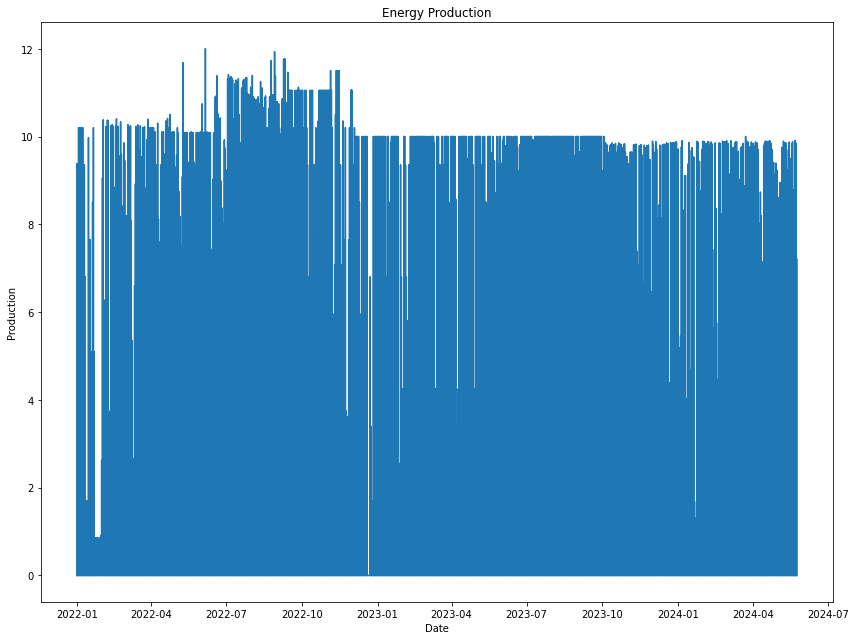

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(production_df['date'], production_df['production'])
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Energy Production')
plt.tight_layout()

There are values > 10 which we will cut to 10 since this pattern isn't observed in current dates.

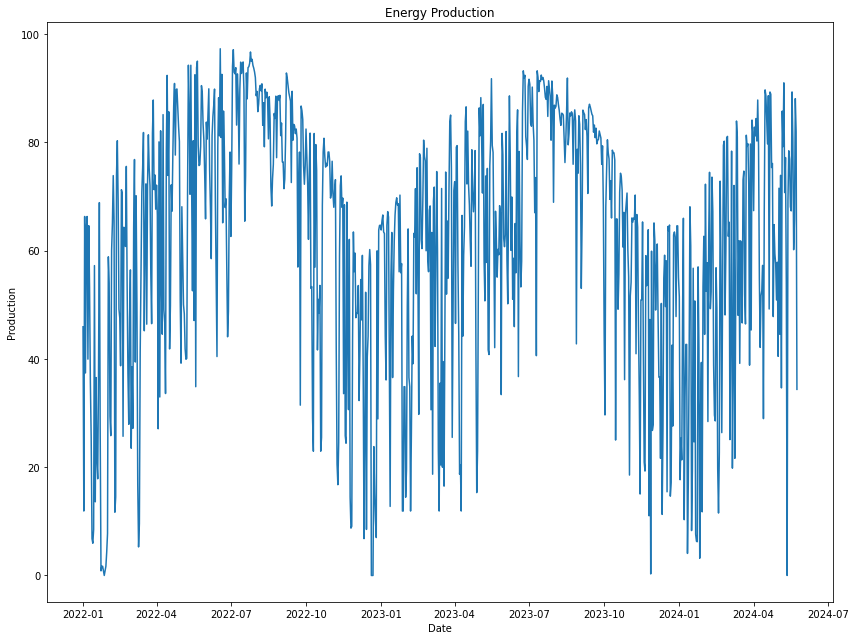

In [14]:
daily_prod_df = production_df.groupby('date')['production'].sum()
plt.figure(figsize=(12, 9))
plt.plot(daily_prod_df.index, daily_prod_df)
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Energy Production')
plt.tight_layout()

Text(0.5, 1.0, 'Observation Coordinates')

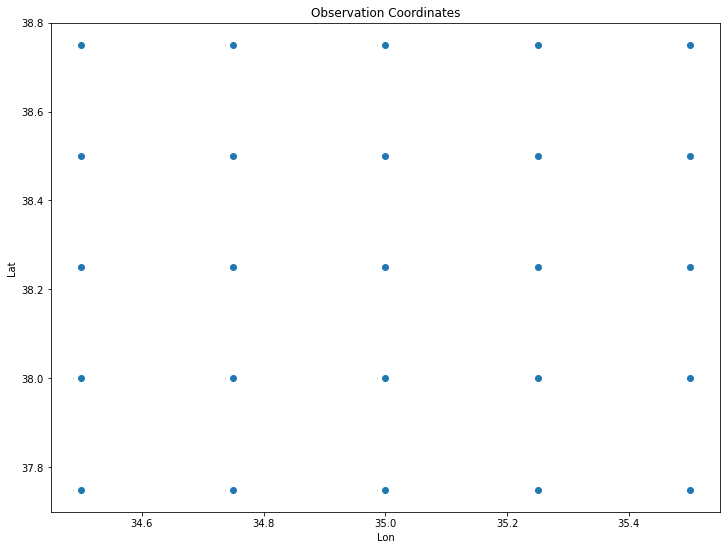

In [15]:
weather_df['lat-lon'] = weather_df['lat'].astype(str) + ' - ' +  weather_df['lon'].astype(str)
coordinate_pt_df = weather_df[['lat', 'lon', 'lat-lon']].drop_duplicates(keep='first')

plt.figure(figsize=(12, 9))
plt.scatter(coordinate_pt_df['lon'], coordinate_pt_df['lat'])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title('Observation Coordinates')

In [16]:
# Merging production and weather dfs on time
prod_info_df = weather_df.merge(production_df, how='inner', on=['date', 'hour']).sort_values(['date', 'hour'])

### Zero Production Hours

In [17]:
# Get normalized hourly production value counts
zero_prod_df = prod_info_df.groupby('hour')['production'].value_counts(normalize=True).to_frame().reset_index(level=1)
# Get zero production hours
zero_prod_df = zero_prod_df[zero_prod_df['production']==0]
zero_prod_df.sort_values('proportion', ascending=False).head(11)

,production,proportion
hour,,
0,0.0,1.000000
1,0.0,1.000000
22,0.0,1.000000
21,0.0,1.000000
20,0.0,1.000000
23,0.0,1.000000
2,0.0,1.000000
3,0.0,1.000000
19,0.0,0.996571


In [18]:
prod_info_df[(prod_info_df['hour']==4)&(prod_info_df['production']!=0)]['production'].mean()

0.06924242424242424

Hour 4 will be included in zero production hour category because it has very low mean.

In [19]:
zero_prod_hours = zero_prod_df[zero_prod_df['proportion'] > .9].index.tolist()
# Dropping zero hours
prod_info_df = prod_info_df[~prod_info_df['hour'].isin(zero_prod_hours)]

zero_prod_hours

[0, 1, 2, 3, 4, 19, 20, 21, 22, 23]

### Coordinate Aggregation

In [20]:
# Equal weighting, same with taking the mean (was different at first)
coordinate_pt_df['weight'] = 1/len(coordinate_pt_df)
weather_agg_df = weather_df.merge(coordinate_pt_df[['lat-lon', 'weight']], how='inner', on='lat-lon')
weather_agg_df.iloc[:,  4:-2] = (weather_agg_df.iloc[:,  4:-2] * weather_agg_df['weight'].to_numpy()[:, None]).astype(float)
weather_agg_df = weather_agg_df.groupby(['date', 'hour'])[weather_agg_df.iloc[[0],  4:-2].columns].sum().reset_index()
weather_agg_df.head()

,date,hour,dswrf_surface,tcdc_low.cloud.layer,tcdc_middle.cloud.layer,tcdc_high.cloud.layer,tcdc_entire.atmosphere,uswrf_top_of_atmosphere,csnow_surface,dlwrf_surface,uswrf_surface,tmp_surface
0,2022-01-01,4,0.0,2.384,5.944,4.604,14.296,0.0,0.0,227.999,0.0,269.220
1,2022-01-01,5,0.0,2.784,4.324,10.636,19.272,0.0,0.0,227.774,0.0,269.104
2,2022-01-01,6,0.0,2.964,5.372,11.688,21.772,0.0,0.0,227.764,0.0,269.035
3,2022-01-01,7,0.0,3.284,9.212,20.736,31.992,0.0,0.0,228.196,0.0,269.001
4,2022-01-01,8,0.0,3.672,11.252,26.432,38.376,0.0,0.0,228.657,0.0,269.002


In [21]:
# Construct new production df with aggregated weather features & get 0 production hour points' index
energy_prod_df = weather_agg_df.merge(production_df, how='inner', on=['date', 'hour'])
zero_prod_hr_idx = energy_prod_df[energy_prod_df['hour'].isin(zero_prod_hours)].index

# Checking if sorting is needed
(energy_prod_df.sort_values(['date', 'hour']).index != energy_prod_df.index).sum()

0

### Special Days

In [22]:
sp_day_df = production_df.groupby('date')[['production']].sum().merge(holiday_df, how='inner', on='date')

In [23]:
sp_day_df.groupby('type')['production'].mean().sort_values(ascending=False)

type
15 temmuz                  92.755000
kurban bayrami             84.912000
zafer bayrami              81.485000
cocuk bayrami              79.090000
cumhuriyet bayrami         73.957500
secim                      63.646667
genclik ve spor bayrami    58.733333
ramazan bayrami            57.398333
isci bayrami               55.343333
yilbasi                    53.730000
Name: production, dtype: float64

In [24]:
sp_day_df['production'].mean()

69.19644444444445

It seems like special days have no effect, some are higher than the average while others are lower. This is probably due to their dates & weather conditions on that season.

### Feature Analysis

<Axes: >

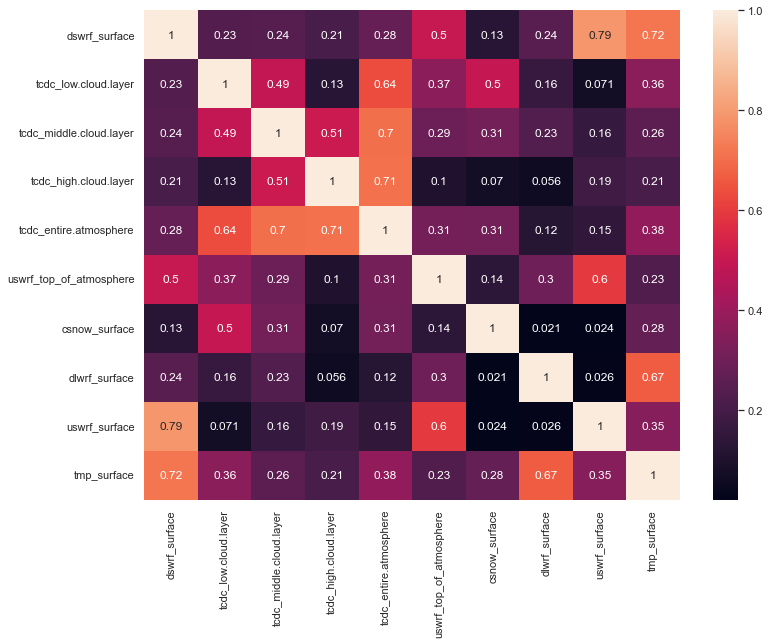

In [25]:
sns.set_theme(rc={'figure.figsize':(12, 9)})
sns.heatmap(prod_info_df.drop('lat-lon', axis=1).iloc[:, 4:-1].corr().abs(), annot=True)

There are significant correlation amongst some features, this might lead to overfit apart from hurting interpretability. Features will be selected iteratively with tests since we have no concern of interpretability.

In [26]:
# Weekend average
energy_prod_df[(pd.to_datetime(energy_prod_df['date']).dt.dayofweek > 4)].groupby('date')['production'].sum().mean()

61.28283999999999

In [27]:
# Weekday average
energy_prod_df[(pd.to_datetime(energy_prod_df['date']).dt.dayofweek <= 4)].groupby('date')['production'].sum().mean()

62.182912

No difference between weekdays and weekends, it is understandable since solar power availability doesn't matter on this feature.

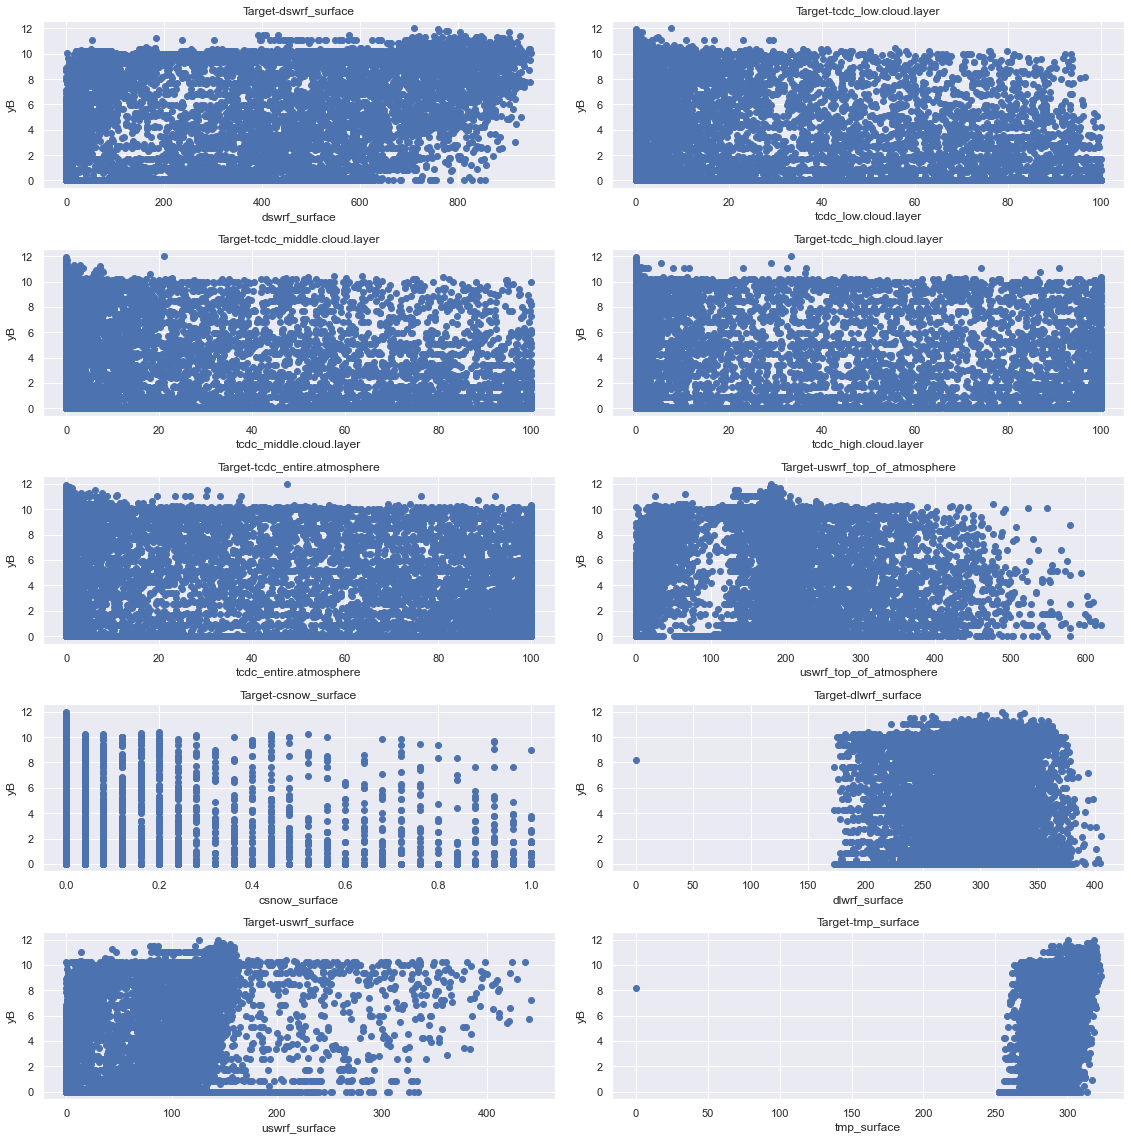

In [28]:
# Plot the relation between target and the base features
fig, ax_arr = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))

a = 1
for i in range(5):
    for j in range(2):
        ax = ax_arr[i, j]
        comp_feature = energy_prod_df.columns[a+1]
        ax.scatter(energy_prod_df.drop(zero_prod_hr_idx.to_list())[comp_feature], (energy_prod_df['production']).drop(zero_prod_hr_idx.to_list()))
        ax.set_title('Target-' + comp_feature)
        ax.set_xlabel(comp_feature)
        ax.set_ylabel('yB')
        a+=1

plt.tight_layout()
plt.show()

No apparent relation other than CSNOW > .5 have lower mean.

## Daily Analysis

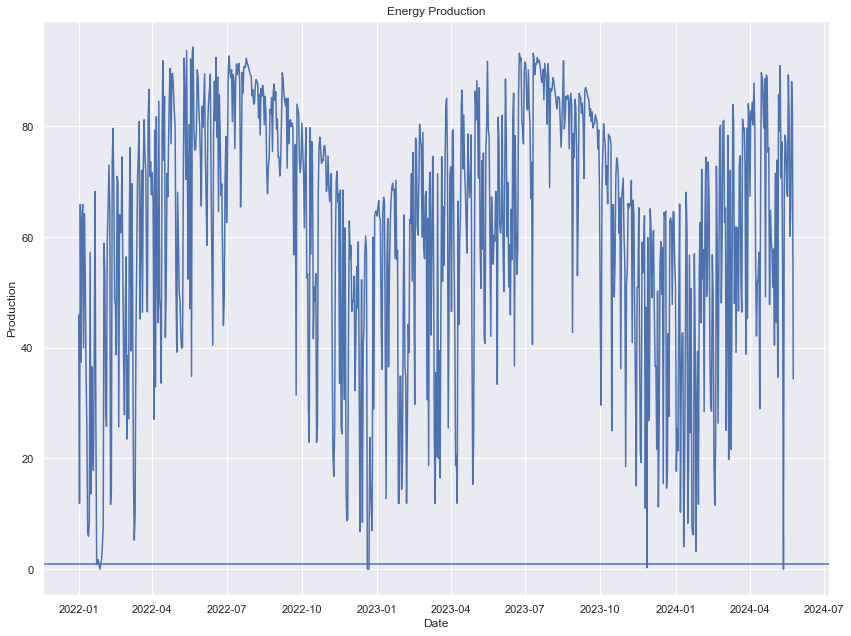

In [29]:
daily_prod_df = energy_prod_df[['date', 'production']]
daily_prod_df.loc[:, 'production'] = np.clip(daily_prod_df['production'], a_min=0, a_max=10)
daily_prod_df = daily_prod_df.groupby('date')['production'].sum()

plt.figure(figsize=(12, 9))
plt.plot(daily_prod_df.index, daily_prod_df)
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Energy Production')
plt.axhline(1)
plt.tight_layout()

By eye (and from the data since by analyzing production and cloud-snow levels), below 1 kW daily production seems anormal, therefore can be removed.

In [30]:
daily_prod_df.quantile(.25) - 1.5*(daily_prod_df.quantile(.75) - daily_prod_df.quantile(.25))

-0.9949999999999903

Since it is too low, 12 will be used to eliminate outliers, it is kind of in same point as .05 quantile.

In [31]:
daily_prod_df.quantile(.05)

13.345000000000002

In [32]:
daily_weather_df = weather_agg_df[~weather_agg_df['hour'].isin(zero_prod_hours)].groupby('date')[weather_agg_df.iloc[:, 2:].columns].mean()
daily_weather_max_df = weather_agg_df.groupby('date')[weather_agg_df.iloc[:, 2:].columns].max()
daily_weather_min_df = weather_agg_df.groupby('date')[weather_agg_df.iloc[:, 2:].columns].min()

In [33]:
# Aggregated cloud features based on their correlations, increased the importance of low cloud layer while still considering middle & high layers
daily_weather_df.loc[:, 'Cloud Level'] = (daily_weather_df['tcdc_entire.atmosphere']+daily_weather_df['tcdc_low.cloud.layer'])/2

daily_prod_info_df = daily_weather_df.join(daily_prod_df, how='inner').sort_index()
daily_prod_info_df.head()

,dswrf_surface,tcdc_low.cloud.layer,tcdc_middle.cloud.layer,tcdc_high.cloud.layer,tcdc_entire.atmosphere,uswrf_top_of_atmosphere,csnow_surface,dlwrf_surface,uswrf_surface,tmp_surface,Cloud Level,production
date,,,,,,,,,,,,
2022-01-01,165.402171,11.473429,31.856000,36.637143,61.412286,101.095040,0.00,240.074429,51.737280,274.611857,36.442857,45.93
2022-01-02,54.792457,89.035714,76.908000,60.901714,93.124571,170.260171,0.68,304.295671,21.538606,274.236434,91.080143,11.90
2022-01-03,192.465543,4.506286,0.648857,2.871143,8.636857,94.422674,0.00,208.612960,68.734034,271.896214,6.571571,65.90
2022-01-04,133.495086,2.176286,79.391143,92.224286,94.786857,136.902903,0.00,257.090786,46.511497,273.940500,48.481571,37.40
2022-01-05,184.936571,0.146571,18.620571,10.590571,26.472571,95.916251,0.00,233.920571,62.066971,274.731726,13.309571,63.35


In [34]:
# Dates are analyzed by eye and this combination of points seems unusual, therefore considered as outliers
outlier_dates = daily_prod_info_df[((daily_prod_info_df['production'] < 12) & (daily_prod_info_df['tcdc_entire.atmosphere'] < 65)) | daily_prod_info_df['production']==0].index
outlier_differenced_dates = outlier_dates+pd.DateOffset(3)
outlier_dates.shape

(4,)

In [35]:
# Lag 3 is closest relaible point
daily_prod_info_df['Prod Diff1'] = daily_prod_info_df['production'] - daily_prod_info_df['production'].shift(3)
daily_prod_info_df = daily_prod_info_df.dropna()

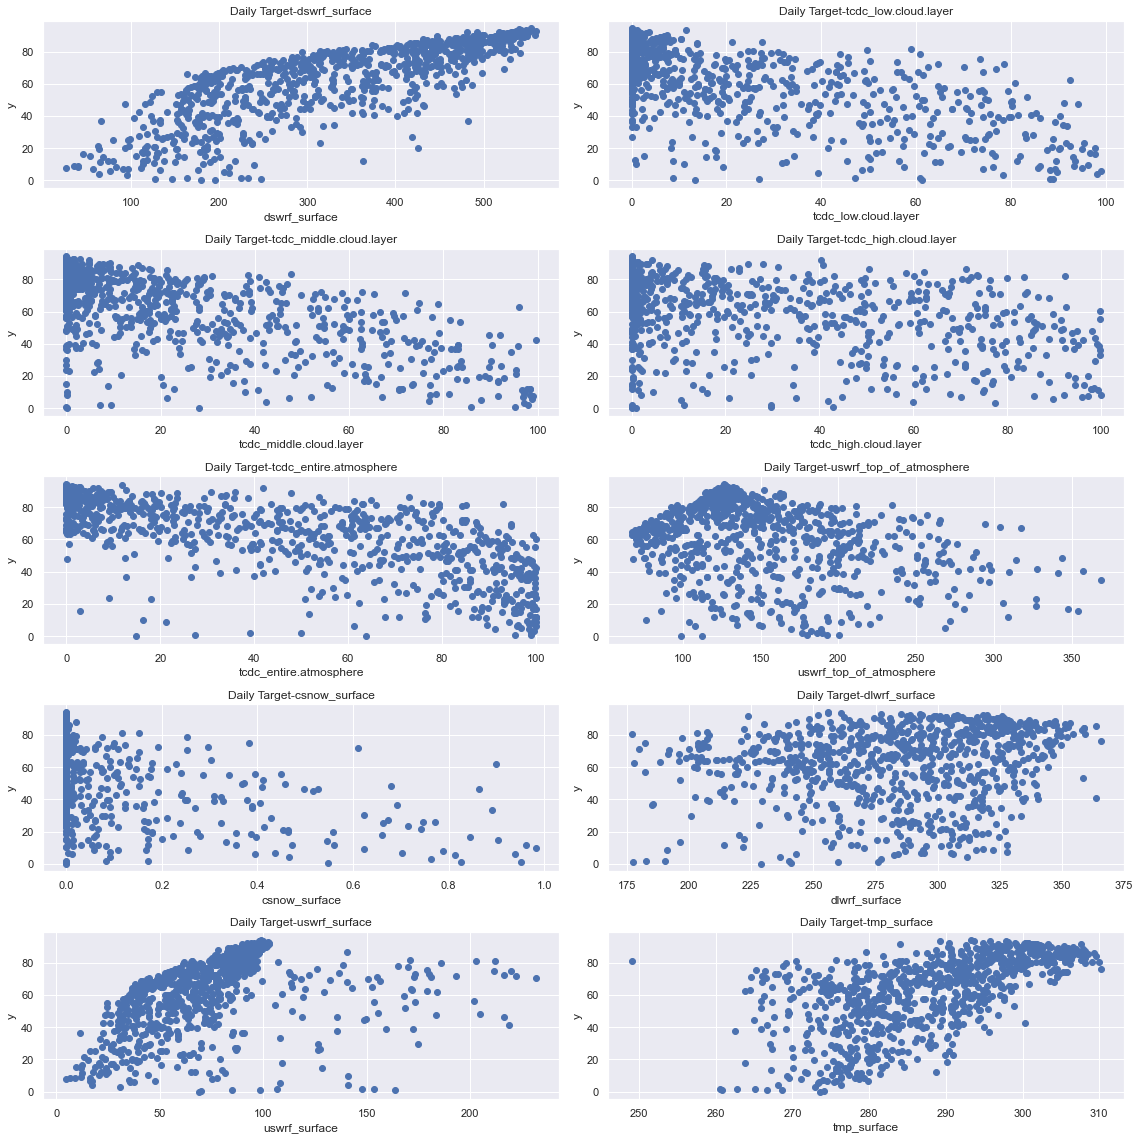

In [38]:
# Plot the relation between the daily target and the base features
fig, ax_arr = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))

a = 0
for i in range(5):
    for j in range(2):
        ax = ax_arr[i, j]
        comp_feature = daily_prod_info_df.columns[a]
        ax.scatter(daily_prod_info_df.drop(outlier_dates)[comp_feature], daily_prod_info_df.drop(outlier_dates)['production'])
        ax.set_title('Daily Target-' + comp_feature)
        ax.set_xlabel(comp_feature)
        ax.set_ylabel('y')
        a+=1

plt.tight_layout()
plt.show()

USWRF features have 2 different pattern but couldn't find the difference between these points (in terms of cloud & snow features).

In [39]:
# DLWRF has log like pattern, therefore transformed with natural log
daily_prod_info_df.loc[:, ['dlwrf_surface']] = np.log(daily_prod_info_df[['dlwrf_surface']]+.1)
daily_weather_max_df.loc[:, ['dlwrf_surface']] = np.log(daily_weather_max_df[['dlwrf_surface']]+.1)
daily_weather_min_df.loc[:, ['dlwrf_surface']] = np.log(daily_weather_min_df[['dlwrf_surface']]+.1)

In [40]:
# Outliers dropped
daily_prod_diff_info_df = daily_prod_info_df[~daily_prod_info_df.index.isin(outlier_dates.tolist()+outlier_differenced_dates.tolist())]
daily_prod_info_df = daily_prod_info_df[~daily_prod_info_df.index.isin(outlier_dates)]

Text(0.5, 1.0, 'Differenced Target')

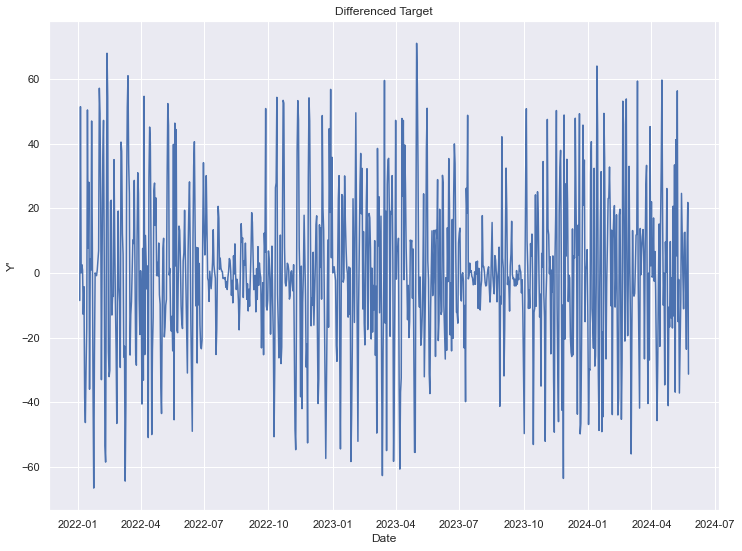

In [41]:
plt.plot(daily_prod_diff_info_df['Prod Diff1'])
plt.xlabel('Date')
plt.ylabel("Y'")
plt.title('Differenced Target')

3

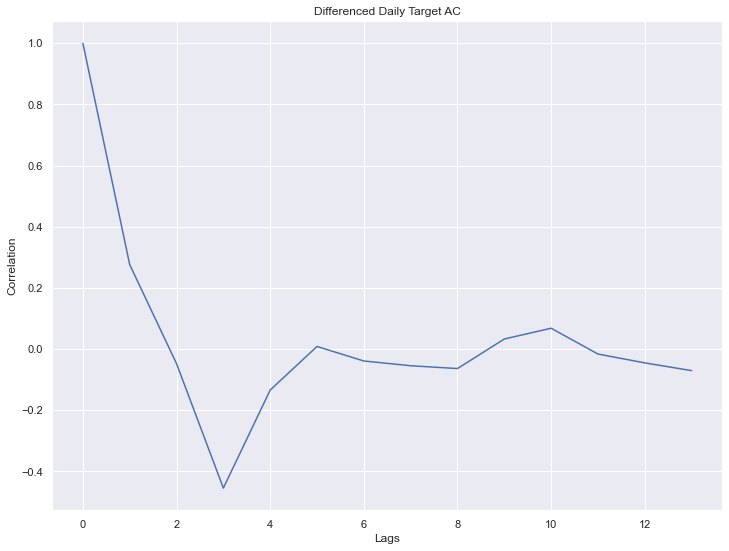

In [42]:
best_autocor_lag_daily, _ = get_best_lag(daily_prod_diff_info_df['Prod Diff1'], daily_prod_diff_info_df['Prod Diff1'], 14, x_label='Lags', y_label='Correlation', title='Differenced Daily Target AC')
best_autocor_lag_daily

Text(0.5, 1.0, 'Differenced Target PACF')

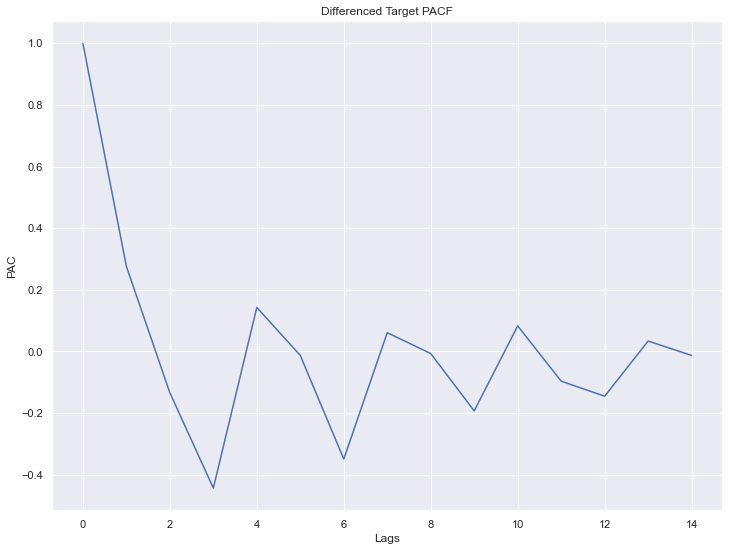

In [43]:
pacf_vals_daily = sm.tsa.pacf(daily_prod_diff_info_df['Prod Diff1'], nlags=14)
plt.plot(pacf_vals_daily)
plt.xlabel('Lags')
plt.ylabel('PAC')
plt.title('Differenced Target PACF')

ACF has a spike at lag 3 while PACF dies out more gradually, which indicates MA(3) pattern (even seasonal pattern but it is not considered). Even though first lag autocorrelation is positive, lag 2 and 3 have high negative correlation which can explain the MA pattern. Daily differenced series seems to have a moving average pattern with h=3, so daily production can also be modelled as ARIMA(0, 1, 3).

Note: We checked all features for up to 30 lag correlations with the target, but only showed Cloud Level feature to shorten the report.

3

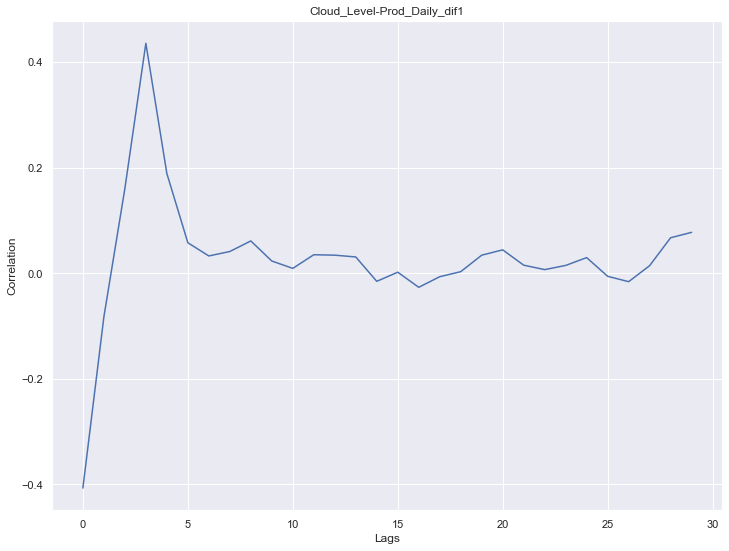

In [44]:
best_cloud_lag_daily, _ = get_best_lag(daily_prod_diff_info_df['Cloud Level'], daily_prod_diff_info_df['Prod Diff1'], 30, x_label='Lags', y_label='Correlation', title='Cloud_Level-Prod_Daily_dif1')
best_cloud_lag_daily

All features can be added to daily model up to lag 8, except tempeture which doesn't seem to have a linear relation. It is known that higher tempetures makes electricity conversion process more inefficient, however, it is not that relevant for this facility's production as seen in feature analysis section.

### LR Models w/Daily Target

In [45]:
hr_weight_info_df = production_df.iloc[:-1].copy()
hr_weight_info_df['month'] = hr_weight_info_df['date'].dt.month

# Drop the yesterday since it is generally wrong
weight_drop_dates = ['2024-05-24 00:00:00']
hr_weight_info_df = hr_weight_info_df[(~hr_weight_info_df['date'].isin(weight_drop_dates)) & (~hr_weight_info_df['date'].isin(outlier_dates))]

<ipython-input-45-78e4a1c5e471>:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hr_weight_info_df = hr_weight_info_df[(~hr_weight_info_df['date'].isin(weight_drop_dates)) & (~hr_weight_info_df['date'].isin(outlier_dates))]


In [46]:
agg_weights = hr_weight_info_df[(hr_weight_info_df['date'].dt.month.isin([4, 5, 6]))].groupby('hour')['production'].sum()
agg_weights = (agg_weights / agg_weights.sum()).round(4)
agg_weights.sum()

0.9999

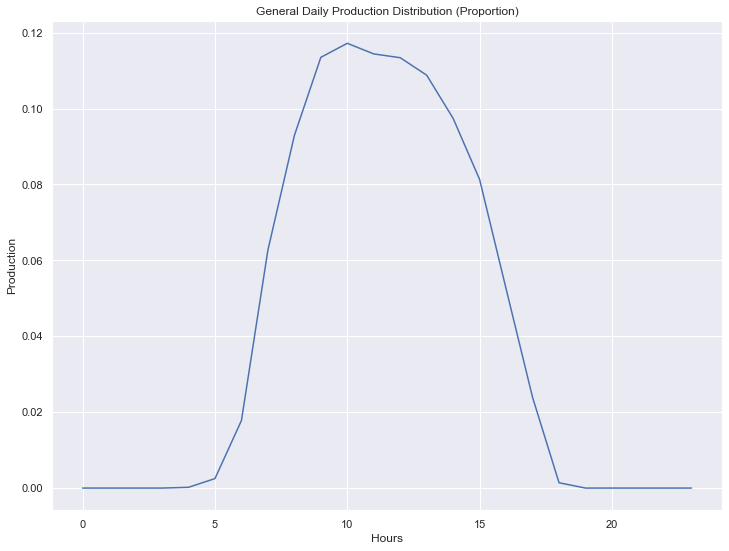

In [47]:
plt.plot(agg_weights)
plt.xlabel('Hours')
plt.ylabel('Production')
plt.title('General Daily Production Distribution (Proportion)')
plt.show()

In [48]:
w_days = agg_weights.values
w_days

array([0.    , 0.    , 0.    , 0.    , 0.0002, 0.0025, 0.0178, 0.0627,
       0.0929, 0.1135, 0.1172, 0.1144, 0.1134, 0.1088, 0.0974, 0.0813,
       0.0525, 0.0239, 0.0014, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [49]:
zero_prod_hours

[0, 1, 2, 3, 4, 19, 20, 21, 22, 23]

They almost exactly allign which is a good thing.

#### LR Model w/Daily Target

In [50]:
y_daily = daily_prod_info_df['production']

# Prediction setup
day_before = '2024-05-24'
current_date = '2024-05-25'
pred_date = '2024-05-26'
daily_prod_info_df.loc[current_date] = None
daily_prod_info_df.loc[pred_date] = None
daily_prod_info_df.loc[current_date, daily_weather_df.columns] = daily_weather_df[daily_weather_df.index==current_date].values
daily_prod_info_df.loc[pred_date, daily_weather_df.columns] = daily_weather_df[daily_weather_df.index==pred_date].values
daily_prod_info_df.index = pd.to_datetime(daily_prod_info_df.index)

In [51]:
# Feature lag dfs for max weather features
dswrf_feature_max_df = get_feature_lag(daily_weather_max_df, 'dswrf_surface', n_lags=7, n_lag_start=0)
uswrf_feature_max_df = get_feature_lag(daily_weather_max_df, 'uswrf_top_of_atmosphere', n_lags=7, n_lag_start=0)
csnow_feature_max_df = get_feature_lag(daily_weather_max_df, 'csnow_surface', n_lags=7, n_lag_start=0)
dlwrf_feature_max_df = get_feature_lag(daily_weather_max_df, 'dlwrf_surface', n_lags=7, n_lag_start=0)
uswrf_surf_feature_max_df = get_feature_lag(daily_weather_max_df, 'uswrf_surface', n_lags=7, n_lag_start=0)

day_weath_max_ft_df = dswrf_feature_max_df.join(uswrf_feature_max_df).join(csnow_feature_max_df).join(dlwrf_feature_max_df).join(uswrf_surf_feature_max_df)

In [52]:
# Feature lag dfs for min weather features
dswrf_feature_min_df = get_feature_lag(daily_weather_min_df, 'dswrf_surface', n_lags=7, n_lag_start=0)
uswrf_feature_min_df = get_feature_lag(daily_weather_min_df, 'uswrf_top_of_atmosphere', n_lags=7, n_lag_start=0)
csnow_feature_min_df = get_feature_lag(daily_weather_min_df, 'csnow_surface', n_lags=7, n_lag_start=0)
dlwrf_feature_min_df = get_feature_lag(daily_weather_min_df, 'dlwrf_surface', n_lags=7, n_lag_start=0)
uswrf_surf_feature_min_df = get_feature_lag(daily_weather_min_df, 'uswrf_surface', n_lags=7, n_lag_start=0)

day_weath_min_ft_df = csnow_feature_min_df.join(dswrf_feature_min_df).join(uswrf_feature_min_df).join(dlwrf_feature_min_df).join(uswrf_surf_feature_min_df)

In [53]:
# Feature lag dfs for mean weather features
dswrf_feature_df = get_feature_lag(daily_prod_info_df, 'dswrf_surface', n_lags=7, n_lag_start=1)
uswrf_feature_df = get_feature_lag(daily_prod_info_df, 'uswrf_top_of_atmosphere', n_lags=7, n_lag_start=1)
csnow_feature_df = get_feature_lag(daily_prod_info_df, 'csnow_surface', n_lags=7, n_lag_start=1)
dlwrf_feature_df = get_feature_lag(daily_prod_info_df, 'dlwrf_surface', n_lags=7, n_lag_start=1)
uswrf_surf_feature_df = get_feature_lag(daily_prod_info_df, 'uswrf_surface', n_lags=7, n_lag_start=1)

In [54]:
# Daily feature matrix
X_daily = sm.add_constant(daily_prod_info_df.drop(['production', 'Prod Diff1', 'tcdc_low.cloud.layer', 'tcdc_middle.cloud.layer',
                                                   'tcdc_high.cloud.layer', 'tcdc_entire.atmosphere', 'tmp_surface'], axis=1))
X_daily['CSNOW>.5'] = np.where(X_daily['csnow_surface'] > .4, 1, 0)
X_daily = X_daily.join(dswrf_feature_df).join(uswrf_feature_df).join(csnow_feature_df).join(dlwrf_feature_df).join(uswrf_surf_feature_df).dropna()
X_daily = X_daily.join(day_weath_max_ft_df, rsuffix=' Max').join(day_weath_min_ft_df, rsuffix=' Min')

# Season & trend features, cloud level features are included this way to account for them in only certain months
# Some months cloud levels are significant while other months they are not & causes overfit, we couldn't understand the reason
month_df = pd.get_dummies(daily_prod_info_df.index.month).astype(int).astype(float)
for col in month_df.columns:
    month_df.loc[:, col] = daily_prod_info_df['Cloud Level'].values * month_df[col]
month_df.index = daily_prod_info_df.index
X_daily = X_daily.join(month_df)

X_daily = X_daily.drop('Cloud Level', axis=1)
X_daily['trend'] = range(1, len(X_daily)+1)

# Prediction point
X_pred = X_daily.loc[[pred_date], :]

# Day before data may be wrong, so dropped
X_daily = X_daily.drop([day_before, current_date, pred_date])
X_daily = X_daily[~X_daily.index.isin(outlier_dates)]
y_daily = y_daily.loc[X_daily.index]

In [55]:
# Initial lasso to select the base features, this is not for evaluating but rather for initial feature filtering
base_daily_lasso = LassoCV(alphas=np.logspace(-6, 2, 500), max_iter=10000, random_state=0)
base_scaler = StandardScaler()
X_daily_scaled = base_scaler.fit_transform(X_daily.values)
X_daily_scaled[:, 0] = 1
base_daily_lasso.fit(X_daily_scaled, y_daily)
base_daily_lasso.score(X_daily_scaled, y_daily)

0.7795651068143999

In [56]:
base_daily_lr_coefs = base_daily_lasso.coef_
selected_cols = X_daily.columns[base_daily_lr_coefs!=0].tolist()
selected_cols

['dswrf_surface',
 'csnow_surface',
 'uswrf_surface- lag1',
 'uswrf_surface- lag2',
 'dswrf_surface- lag0',
 'uswrf_top_of_atmosphere- lag0',
 'csnow_surface- lag0',
 'csnow_surface- lag2 Max',
 'csnow_surface- lag0 Min',
 'csnow_surface- lag1 Min',
 'csnow_surface- lag2 Min',
 'csnow_surface- lag5 Min',
 'csnow_surface- lag6 Min',
 'dlwrf_surface- lag3 Min',
 1,
 2,
 4,
 10,
 11,
 12,
 'trend']

In [57]:
lr_daily_sm = sm.OLS(y_daily, sm.add_constant(X_daily[selected_cols])).fit()
lr_daily_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             production   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     148.3
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          4.35e-265
Time:                        12:10:14   Log-Likelihood:                -3249.9
No. Observations:                 860   AIC:                             6544.
Df Residuals:                     838   BIC:                             6649.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            61.3073      8.142      7.529      0.000      45.325      77.289
dswrf_surface                     0.0708      0.024      3.000      0.003       0.024       0.117
csnow_surface                    -5.9642      6.418     -0.929      0.353     -18.562       6.633
uswrf_surface- lag1               0.0812      0.024      3.408      0.001       0.034       0.128
uswrf_surface- lag2               0.0326      0.022      1.461      0.144      -0.011       0.076
dswrf_surface- lag0               0.0030      0.015      0.200      0.841      -0.026       0.032
uswrf_top_of_atmosphere- lag0    -0.0642      0.004    -15.050      0.000      -0.073      -0.056
csnow_surface- lag0              -5.9003      3.570     -1.653      0.099     -12.907       1.107
csnow_surface- lag2 Max          -2.8193      2.067     -1.364      0.173      -6.876       1.238
csnow_surface- lag0 Min          -7.3446      9.512     -0.772      0.440     -26.015      11.326
csnow_surface- lag1 Min          -5.4903      7.174     -0.765      0.444     -19.572       8.592
csnow_surface- lag2 Min          -2.6675      7.504     -0.355      0.722     -17.397      12.062
csnow_surface- lag5 Min         -15.7430      6.419     -2.452      0.014     -28.343      -3.143
csnow_surface- lag6 Min          -8.9262      6.417     -1.391      0.165     -21.521       3.668
dlwrf_surface- lag3 Min          -2.1026      1.370     -1.535      0.125      -4.791       0.586
1                                -0.2789      0.029     -9.655      0.000      -0.336      -0.222
2                                -0.1114      0.027     -4.089      0.000      -0.165      -0.058
4                                -0.1058      0.027     -3.987      0.000      -0.158      -0.054
10                               -0.1522      0.047     -3.235      0.001      -0.245      -0.060
11                               -0.2820      0.038     -7.509      0.000      -0.356      -0.208
12                               -0.2333      0.038     -6.095      0.000      -0.308      -0.158
trend                             0.0037      0.002      2.234      0.026       0.000       0.007
==============================================================================
Omnibus:                      206.621   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              607.574
Skew:                          -1.184   Prob(JB):                    1.17e-132
Kurtosis:                       6.368   Cond. No.                     2.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+04. This might indi

In [58]:
# Selected with considering significance & test trials
sm_drop_cols = ['dswrf_surface- lag0', 'csnow_surface', 'uswrf_surface- lag2', 'dlwrf_surface- lag3 Min', 'csnow_surface- lag6 Min']

In [59]:
lr_daily_sm = sm.OLS(y_daily, sm.add_constant(X_daily[selected_cols].drop(sm_drop_cols, axis=1))).fit()
lr_daily_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             production   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     193.7
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          3.85e-269
Time:                        12:10:14   Log-Likelihood:                -3253.7
No. Observations:                 860   AIC:                             6541.
Df Residuals:                     843   BIC:                             6622.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            50.6148      2.384     21.230      0.000      45.935      55.294
dswrf_surface                     0.0754      0.005     15.816      0.000       0.066       0.085
uswrf_surface- lag1               0.1068      0.016      6.621      0.000       0.075       0.138
uswrf_top_of_atmosphere- lag0    -0.0645      0.004    -15.342      0.000      -0.073      -0.056
csnow_surface- lag0              -7.8543      2.243     -3.501      0.000     -12.257      -3.451
csnow_surface- lag2 Max          -3.0749      2.051     -1.499      0.134      -7.100       0.950
csnow_surface- lag0 Min         -14.1512      7.352     -1.925      0.055     -28.582       0.280
csnow_surface- lag1 Min          -3.8831      6.952     -0.559      0.577     -17.528       9.762
csnow_surface- lag2 Min          -5.3824      7.294     -0.738      0.461     -19.700       8.935
csnow_surface- lag5 Min         -15.4263      6.227     -2.477      0.013     -27.649      -3.204
1                                -0.2803      0.028     -9.850      0.000      -0.336      -0.224
2                                -0.1068      0.027     -3.978      0.000      -0.160      -0.054
4                                -0.1038      0.027     -3.909      0.000      -0.156      -0.052
10                               -0.1527      0.047     -3.257      0.001      -0.245      -0.061
11                               -0.2866      0.037     -7.732      0.000      -0.359      -0.214
12                               -0.2365      0.038     -6.268      0.000      -0.311      -0.162
trend                             0.0034      0.002      2.059      0.040       0.000       0.007
==============================================================================
Omnibus:                      210.932   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              629.772
Skew:                          -1.203   Prob(JB):                    1.76e-137
Kurtosis:                       6.433   Cond. No.                     1.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# Outliers in terms of residuals, selected by analyzing the residuals & trial
out_resid_idx = lr_daily_sm.resid[lr_daily_sm.resid.abs().sort_values(ascending=False)>40].index
out_resid_idx

DatetimeIndex(['2022-01-29', '2022-04-03', '2022-10-10', '2022-12-22',
               '2022-12-24', '2022-12-25', '2023-04-08', '2023-04-09',
               '2023-06-18'],
              dtype='datetime64[ns]', name='date', freq=None)

The data points are not very recent, they can be removed from training set to learn other coefficients better and remove unnecessary features to make our model more robust.

In [61]:
# Final lasso feature selection
out_resid_drop_idx = np.where(X_daily.index.isin(out_resid_idx))
X_daily_scaled_2 = np.delete(X_daily_scaled, out_resid_drop_idx, axis=0)

fl_daily_lasso = LassoCV(alphas=np.logspace(-3, 6, 500), max_iter=10000, random_state=0)
fl_daily_lasso.fit(X_daily_scaled_2, y_daily.drop(out_resid_idx))
fl_daily_lasso.score(X_daily_scaled_2, y_daily.drop(out_resid_idx))

0.8222839042140007

In [62]:
final_selected_cols = X_daily.columns[fl_daily_lasso.coef_!=0].tolist()
final_selected_cols

['dswrf_surface',
 'uswrf_top_of_atmosphere',
 'csnow_surface',
 'uswrf_surface',
 'csnow_surface- lag5',
 'dlwrf_surface- lag5',
 'uswrf_surface- lag1',
 'uswrf_surface- lag2',
 'uswrf_surface- lag3',
 'uswrf_surface- lag4',
 'uswrf_surface- lag7',
 'dswrf_surface- lag0',
 'uswrf_top_of_atmosphere- lag0',
 'uswrf_top_of_atmosphere- lag7 Max',
 'csnow_surface- lag0',
 'dlwrf_surface- lag0',
 'csnow_surface- lag0 Min',
 'csnow_surface- lag1 Min',
 'csnow_surface- lag2 Min',
 'csnow_surface- lag5 Min',
 'csnow_surface- lag7 Min',
 'dlwrf_surface- lag0 Min',
 'dlwrf_surface- lag2 Min',
 'dlwrf_surface- lag3 Min',
 'dlwrf_surface- lag4 Min',
 1,
 2,
 4,
 7,
 8,
 10,
 11,
 12,
 'trend']

In [63]:
# Selected with considering significance & test trials
sm_drop_cols = ['csnow_surface', 'uswrf_surface- lag3', 'uswrf_top_of_atmosphere', 'dlwrf_surface- lag2 Min', 'uswrf_top_of_atmosphere- lag7 Max',
                'csnow_surface- lag2 Min', 'dlwrf_surface- lag5', 'dlwrf_surface- lag3 Min', 'dlwrf_surface- lag0 Min', 7, 8, 'uswrf_surface- lag4',
                'csnow_surface- lag1 Min', 'csnow_surface- lag5', 'dswrf_surface- lag0', 'uswrf_surface', 'uswrf_surface- lag7',
                'dlwrf_surface- lag4 Min', 'csnow_surface- lag7 Min', 'dlwrf_surface- lag0', 'trend', 'csnow_surface- lag5 Min']

X_daily_sm = sm.add_constant(X_daily[final_selected_cols].drop(sm_drop_cols, axis=1))
X_daily_sm = X_daily_sm.drop(out_resid_idx)

In [64]:
lr_daily_sm = sm.OLS(y_daily.loc[X_daily_sm.index], X_daily_sm).fit()
lr_daily_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             production   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     316.3
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          2.84e-301
Time:                        12:10:27   Log-Likelihood:                -3133.6
No. Observations:                 851   AIC:                             6293.
Df Residuals:                     838   BIC:                             6355.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            54.4671      1.848     29.477      0.000      50.840      58.094
dswrf_surface                     0.0744      0.004     18.198      0.000       0.066       0.082
uswrf_surface- lag1               0.0556      0.019      2.932      0.003       0.018       0.093
uswrf_surface- lag2               0.0335      0.019      1.785      0.075      -0.003       0.070
uswrf_top_of_atmosphere- lag0    -0.0666      0.004    -17.619      0.000      -0.074      -0.059
csnow_surface- lag0             -10.9218      1.929     -5.663      0.000     -14.707      -7.136
csnow_surface- lag0 Min         -16.0727      6.562     -2.449      0.015     -28.953      -3.193
1                                -0.2885      0.026    -11.250      0.000      -0.339      -0.238
2                                -0.1193      0.024     -4.936      0.000      -0.167      -0.072
4                                -0.0714      0.024     -2.953      0.003      -0.119      -0.024
10                               -0.1557      0.042     -3.702      0.000      -0.238      -0.073
11                               -0.3026      0.033     -9.085      0.000      -0.368      -0.237
12                               -0.2368      0.034     -6.999      0.000      -0.303      -0.170
==============================================================================
Omnibus:                      113.094   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.549
Skew:                          -0.794   Prob(JB):                     4.72e-49
Kurtosis:                       4.938   Cond. No.                     9.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Other than high correlation, everything seems ok.

In [65]:
# Test prediction
np.clip((lr_daily_sm.predict([1]+X_pred[final_selected_cols].drop(sm_drop_cols, axis=1).values[0].tolist()) * w_days/sum(w_days)).round(4).tolist(), a_max=9.85, a_min=0).tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0149,
 0.1864,
 1.3273,
 4.6755,
 6.9275,
 8.4636,
 8.7395,
 8.5307,
 8.4562,
 8.1132,
 7.2631,
 6.0625,
 3.9149,
 1.7822,
 0.1044,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Text(0.5, 1.0, 'Final Residuals')

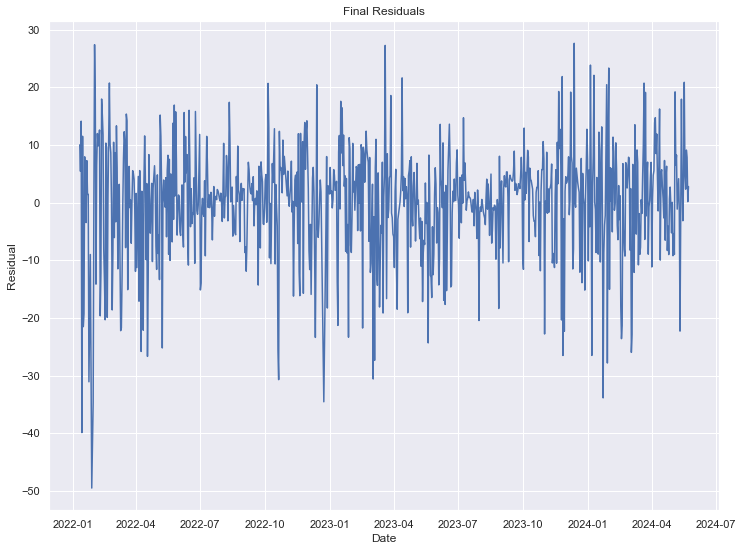

In [66]:
base_daily_residual_df = y_daily - lr_daily_sm.predict(X_daily_sm)
base_daily_residual_df = lr_daily_sm.resid
plt.plot(base_daily_residual_df)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Final Residuals')

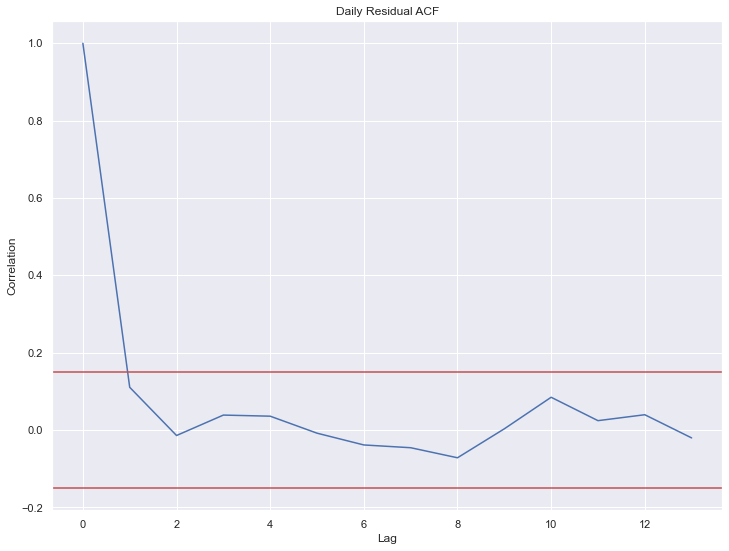

In [67]:
_, daily_dif_res_arr = get_best_lag(base_daily_residual_df, base_daily_residual_df, 14, 'Lag', 'Correlation', 'Daily Residual ACF')
plt.axhline(.15, color='r')
plt.axhline(-.15, color='r')

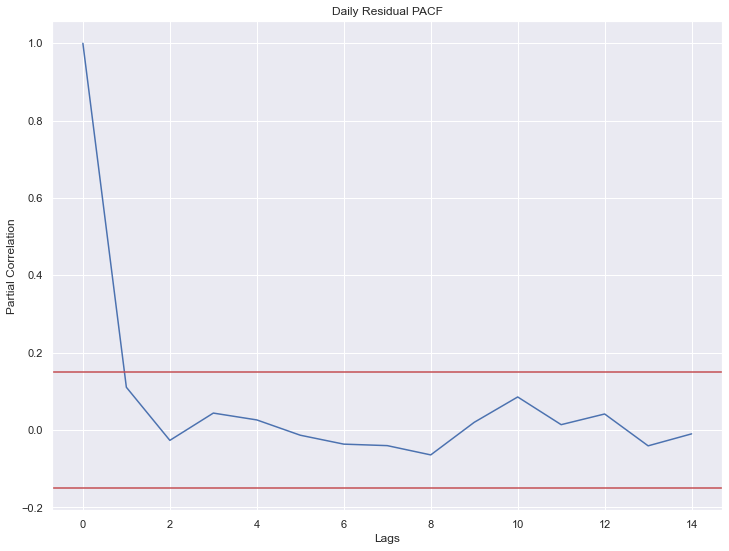

In [68]:
pacf_vals_daily_res = sm.tsa.pacf(base_daily_residual_df, nlags=14)
plt.plot(pacf_vals_daily_res)
plt.xlabel('Lags')
plt.ylabel('Partial Correlation')
plt.title('Daily Residual PACF')
plt.axhline(.15, color='r')
plt.axhline(-.15, color='r')

Residuals seems to be mainly white noise, therefore this model can be considered fine to use in predictions.

In [ ]:
# Don't want outlier dates in the test since we think that their response is very noisy, therefore can add bias to our tests (Only 12 May is removed with this)
cv_dates = y_daily.index[(y_daily.index >= '2024-02-01') & (y_daily.index <= '2024-05-15') & (~y_daily.index.isin(outlier_dates.tolist()))].unique()
daily_cv_df = production_df[production_df['date'].isin(cv_dates)].copy()
daily_cv_df['Prediction'] = None

# TS-CV for daily series
for i, date in enumerate(cv_dates):
    cv_comp_perc = round((i+1)*100/len(cv_dates), 2)
    # Outputs are deleted to shorthen the report
    if cv_comp_perc%10 < len(cv_dates)/10:
        print(f'Iteration {i+1}, Completion %: {cv_comp_perc}')
    
    iter_cv_idx = daily_cv_df[daily_cv_df['date']==date].index
    month = date.month
    X_tr_iter, X_test_iter = split_cv_test_tr(X_daily_sm, date)
    y_tr_iter, _ = split_cv_test_tr(y_daily.loc[X_daily_sm.index], date)
    
    # Train LR & predict test point
    daily_sm_lr = sm.OLS(y_tr_iter, X_tr_iter).fit()
    daily_pred = daily_sm_lr.predict(X_test_iter.values[0])

    # Find daily weights considering close months
    agg_weights = hr_weight_info_df[(hr_weight_info_df['date']<date) & (hr_weight_info_df['date'].dt.month.isin([month-1, month, month+1]))].groupby('hour')['production'].sum()
    agg_weights = (agg_weights / agg_weights.sum()).round(4)

    # Predict hourly productions
    daily_cv_df.loc[iter_cv_idx, 'Prediction'] = (daily_pred * (agg_weights * 1/sum(agg_weights))).values

daily_cv_df['Error'] = daily_cv_df['production'] - daily_cv_df['Prediction']

In [71]:
daily_cv_df['Error'].abs().sum()*100/daily_cv_df['production'].sum()

23.750224990859685

In [72]:
daily_cv_df.iloc[-24:]['Error'].abs().sum()*100/daily_cv_df.iloc[-24:]['production'].sum()

24.00563147599381

In [73]:
daily_cv_df.iloc[-24*7:]['Error'].abs().sum()*100/daily_cv_df.iloc[-24*7:]['production'].sum()

25.33664052543768

In [74]:
daily_cv_df.iloc[-24*30:]['Error'].abs().sum()*100/daily_cv_df.iloc[-24*30:]['production'].sum()

22.109384314987135

<ipython-input-75-e290f5e1f875>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_cv_perf_df = daily_cv_df.groupby('date').apply(process_cv_df)


Text(0.5, 1.0, 'Daily LR TS-CV')

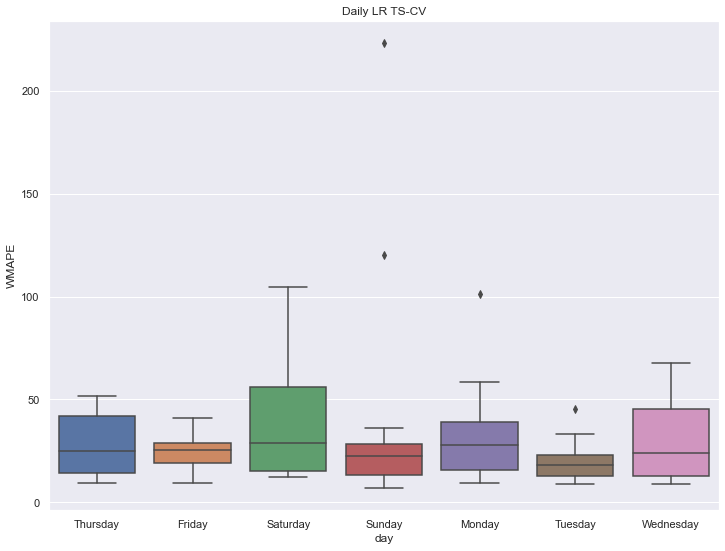

In [75]:
daily_cv_perf_df = daily_cv_df.groupby('date').apply(process_cv_df)
daily_cv_perf_df['day'] = daily_cv_perf_df.index.day_name()

sns.boxplot(daily_cv_perf_df, x='day', y='WMAPE')
plt.title('Daily LR TS-CV')

In [76]:
naive_pred_err = energy_prod_df['production'] - energy_prod_df['production'].shift(48)
naive_pred_err.loc[daily_cv_df.index-4].abs().sum()*100/energy_prod_df['production'].loc[daily_cv_df.index-4].sum()

41.677500301151575

In [77]:
naive_pred_err.loc[daily_cv_df.index-4].iloc[-24:].abs().sum()*100/energy_prod_df['production'].loc[daily_cv_df.index-4].iloc[-24:].sum()

20.10403120936281

In [78]:
naive_pred_err.loc[daily_cv_df.index-4].iloc[-24*7:].abs().sum()*100/energy_prod_df['production'].loc[daily_cv_df.index-4].iloc[-24*7:].sum()

34.28317352304362

In [79]:
naive_pred_err.loc[daily_cv_df.index-4].iloc[-24*30:].abs().sum()*100/energy_prod_df['production'].loc[daily_cv_df.index-4].iloc[-24*30:].sum()

33.020187410197295

The daily model with nondifferenced target is significantly better than naive predictions in the general test period, even though in some days it is worse.

#### LR Model w/Differenced Daily Target

In [80]:
y_diff_daily = daily_prod_diff_info_df['Prod Diff1']
X_diff_daily = X_daily[X_daily.index.isin(y_diff_daily.index)]
y_diff_daily = y_diff_daily.loc[X_diff_daily.index]

In [81]:
base_daily_lasso = LassoCV(n_alphas=1000, max_iter=5000, random_state=0)
base_scaler = StandardScaler()
X_dif_day_scaled = base_scaler.fit_transform(X_diff_daily.values)
base_daily_lasso.fit(X_dif_day_scaled, y_diff_daily)
base_daily_lasso.score(X_dif_day_scaled, y_diff_daily)

0.6349251917607943

In [82]:
base_daily_lr_coefs = base_daily_lasso.coef_
selected_cols = X_daily.columns[base_daily_lr_coefs!=0].tolist()
selected_cols

['uswrf_top_of_atmosphere',
 'dlwrf_surface',
 'uswrf_top_of_atmosphere- lag3',
 'uswrf_top_of_atmosphere- lag7',
 'csnow_surface- lag2',
 'csnow_surface- lag3',
 'csnow_surface- lag4',
 'dlwrf_surface- lag3',
 'uswrf_surface- lag4',
 'uswrf_surface- lag6',
 'uswrf_top_of_atmosphere- lag0',
 'uswrf_top_of_atmosphere- lag3 Max',
 'uswrf_top_of_atmosphere- lag5 Max',
 'csnow_surface- lag0',
 'csnow_surface- lag3 Max',
 'dlwrf_surface- lag0',
 'dlwrf_surface- lag3 Max',
 'csnow_surface- lag0 Min',
 'csnow_surface- lag1 Min',
 'csnow_surface- lag5 Min',
 'dlwrf_surface- lag5 Min',
 'dlwrf_surface- lag6 Min',
 1,
 10,
 11]

In [83]:
lr_dif_day_sm = sm.OLS(y_diff_daily.loc[X_diff_daily.index], sm.add_constant(X_diff_daily[selected_cols])).fit()
lr_dif_day_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prod Diff1   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     59.84
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.33e-166
Time:                        12:11:23   Log-Likelihood:                -3499.9
No. Observations:                 856   AIC:                             7052.
Df Residuals:                     830   BIC:                             7175.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                38.0931     29.745      1.281      0.201     -20.291      96.477
uswrf_top_of_atmosphere              -0.1335      0.037     -3.561      0.000      -0.207      -0.060
dlwrf_surface                       -10.4980     13.809     -0.760      0.447     -37.603      16.606
uswrf_top_of_atmosphere- lag3         0.1596      0.037      4.264      0.000       0.086       0.233
uswrf_top_of_atmosphere- lag7        -0.0179      0.012     -1.510      0.131      -0.041       0.005
csnow_surface- lag2                   4.6435      4.144      1.120      0.263      -3.491      12.778
csnow_surface- lag3                  24.3959      7.518      3.245      0.001       9.639      39.153
csnow_surface- lag4                  10.7706      4.390      2.453      0.014       2.153      19.388
dlwrf_surface- lag3                  -2.8840     14.462     -0.199      0.842     -31.270      25.502
uswrf_surface- lag4                  -0.0049      0.027     -0.182      0.855      -0.058       0.048
uswrf_surface- lag6                  -0.0235      0.026     -0.905      0.366      -0.075       0.028
uswrf_top_of_atmosphere- lag0        -0.0389      0.018     -2.155      0.031      -0.074      -0.003
uswrf_top_of_atmosphere- lag3 Max     0.0315      0.018      1.760      0.079      -0.004       0.067
uswrf_top_of_atmosphere- lag5 Max     0.0079      0.006      1.296      0.195      -0.004       0.020
csnow_surface- lag0                  -8.5147      3.176     -2.681      0.007     -14.748      -2.282
csnow_surface- lag3 Max              -0.6272      5.175     -0.121      0.904     -10.785       9.530
dlwrf_surface- lag0                 -36.4832     13.196     -2.765      0.006     -62.384     -10.583
dlwrf_surface- lag3 Max              37.7317     13.929      2.709      0.007      10.391      65.072
csnow_surface- lag0 Min             -28.1415     10.249     -2.746      0.006     -48.258      -8.025
csnow_surface- lag1 Min             -14.5885      9.336     -1.563      0.119     -32.913       3.736
csnow_surface- lag5 Min             -18.3593      9.853     -1.863      0.063     -37.700       0.981
dlwrf_surface- lag5 Min               3.1412      1.923      1.634      0.103      -0.633       6.915
dlwrf_surface- lag6 Min               2.5913      1.947      1.331      0.184      -1.230       6.413
1                                    -0.0743      0.037     -2.027      0.043      -0.146      -0.002
10                                   -0.1736      0.062     -2.816      0.005      -0.295      -0.053
11                                   -0.1762      0.047     -3.748      0.000      -0.268      -0.084
==============================================================================
Omnibus:                       67.824   Durbin

In [84]:
# Selected with considering significance, coefficients & test trials
sm_drop_cols = ['dlwrf_surface', 'csnow_surface- lag2', 'dlwrf_surface- lag3', 'uswrf_surface- lag6', 'uswrf_top_of_atmosphere- lag3 Max', 10,
                'uswrf_surface- lag4', 'uswrf_top_of_atmosphere- lag5 Max', 'csnow_surface- lag3 Max', 'csnow_surface- lag4', 'csnow_surface- lag0 Min',
                'dlwrf_surface- lag6 Min', 'dlwrf_surface- lag5 Min', 'uswrf_top_of_atmosphere- lag0', 'dlwrf_surface- lag3 Max', 'csnow_surface- lag3',
                'csnow_surface- lag5 Min', 'csnow_surface- lag1 Min', 'uswrf_top_of_atmosphere- lag7']

X_diff_daily_sm = sm.add_constant(X_diff_daily[selected_cols].drop(sm_drop_cols, axis=1))
y_diff_daily_sm = y_diff_daily.loc[X_diff_daily_sm.index]

In [85]:
lr_dif_day_sm = sm.OLS(y_diff_daily_sm, X_diff_daily_sm).fit()
lr_dif_day_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prod Diff1   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     188.8
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.55e-152
Time:                        12:11:23   Log-Likelihood:                -3578.1
No. Observations:                 856   AIC:                             7170.
Df Residuals:                     849   BIC:                             7203.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           187.3800     23.373      8.017      0.000     141.504     233.256
uswrf_top_of_atmosphere          -0.2394      0.013    -18.564      0.000      -0.265      -0.214
uswrf_top_of_atmosphere- lag3     0.2859      0.011     24.981      0.000       0.263       0.308
csnow_surface- lag0             -13.0909      2.699     -4.851      0.000     -18.388      -7.794
dlwrf_surface- lag0             -33.5613      4.132     -8.123      0.000     -41.671     -25.452
1                                -0.0622      0.037     -1.681      0.093      -0.135       0.010
11                               -0.1335      0.049     -2.744      0.006      -0.229      -0.038
==============================================================================
Omnibus:                       34.300   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.168
Skew:                           0.146   Prob(JB):                     3.21e-19
Kurtosis:                       4.518   Cond. No.                     9.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
# Adding the residual lag3 as features since daily differenced target shows ARIMA(0, 1, 3) pattern
X_diff_daily_sm_2 = X_diff_daily_sm.copy()
X_diff_daily_sm_2['res_lag3'] = lr_dif_day_sm.resid.shift(3)
X_diff_daily_sm_2 = X_diff_daily_sm_2.dropna()

In [87]:
lr_dif_day_sm = sm.OLS(y_diff_daily_sm.iloc[3:], X_diff_daily_sm_2).fit()
lr_dif_day_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prod Diff1   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     203.4
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          2.03e-176
Time:                        12:11:23   Log-Likelihood:                -3503.4
No. Observations:                 853   AIC:                             7023.
Df Residuals:                     845   BIC:                             7061.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           166.1702     21.855      7.603      0.000     123.274     209.067
uswrf_top_of_atmosphere          -0.2507      0.012    -20.827      0.000      -0.274      -0.227
uswrf_top_of_atmosphere- lag3     0.2891      0.011     27.128      0.000       0.268       0.310
csnow_surface- lag0             -10.1241      2.527     -4.006      0.000     -15.084      -5.164
dlwrf_surface- lag0             -29.7001      3.864     -7.687      0.000     -37.284     -22.116
1                                -0.0628      0.036     -1.766      0.078      -0.133       0.007
11                               -0.1222      0.045     -2.699      0.007      -0.211      -0.033
res_lag3                         -0.3734      0.032    -11.606      0.000      -0.437      -0.310
==============================================================================
Omnibus:                       23.254   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.697
Skew:                          -0.106   Prob(JB):                     4.39e-11
Kurtosis:                       4.139   Cond. No.                     9.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Final Residuals')

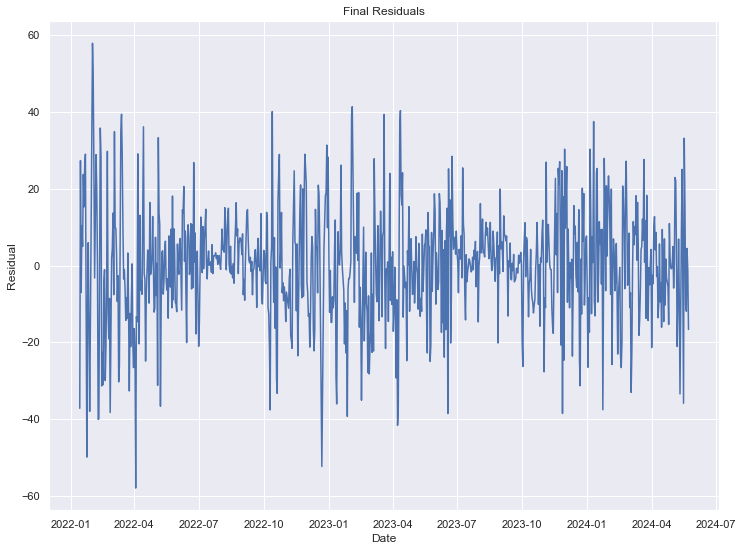

In [88]:
base_diff_day_res_df = lr_dif_day_sm.resid
plt.plot(base_diff_day_res_df)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Final Residuals')

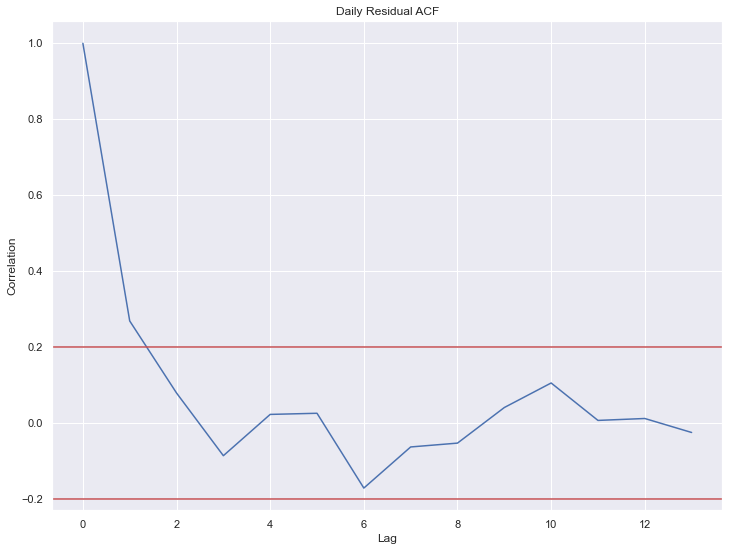

In [89]:
_, daily_dif_res_arr = get_best_lag(base_diff_day_res_df, base_diff_day_res_df, 14, 'Lag', 'Correlation', 'Daily Residual ACF')
plt.axhline(.2, color='r')
plt.axhline(-.2, color='r')

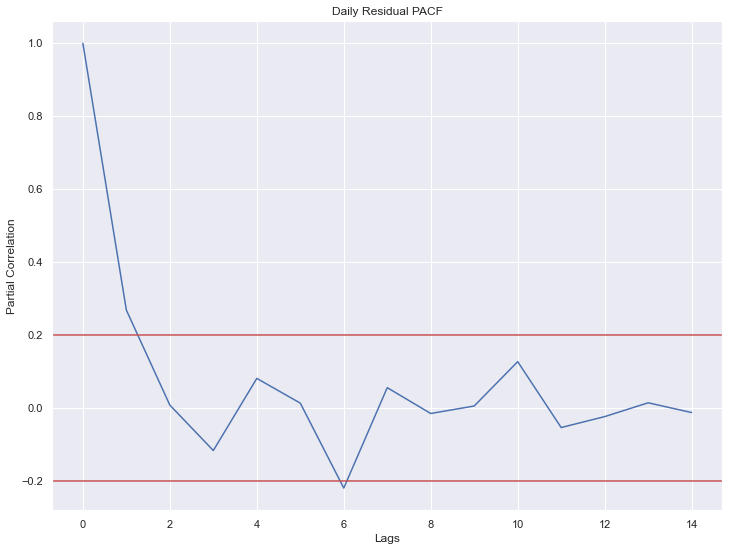

In [90]:
pacf_vals_daily_res = sm.tsa.pacf(base_diff_day_res_df, nlags=14)
plt.plot(pacf_vals_daily_res)
plt.xlabel('Lags')
plt.ylabel('Partial Correlation')
plt.title('Daily Residual PACF')
plt.axhline(.2, color='r')
plt.axhline(-.2, color='r')

MA(3) pattern is explained, there is little correlation with lag6 as well, however it can be ignored since it is ~ 0.2 

In [ ]:
# Don't want outlier dates in the test since we think that their response is very noisy, therefore can add bias to our tests (Only 12 & 15 May is removed with this)
cv_dates = y_daily.index[(y_daily.index >= '2024-02-01') & (y_daily.index <= '2024-05-15') & (~y_daily.index.isin(outlier_dates.tolist() + outlier_differenced_dates.tolist()))].unique()
daily_diff_cv_df = production_df[production_df['date'].isin(cv_dates)].copy()
daily_diff_cv_df['Prediction'] = None

# TS-CV for daily differenced series
for i, date in enumerate(cv_dates):
    cv_comp_perc = round((i+1)*100/len(cv_dates), 2)
    if cv_comp_perc%10 < len(cv_dates)/10:
        print(f'Iteration {i+1}, Completion %: {cv_comp_perc}')
    
    iter_cv_idx = daily_diff_cv_df[daily_diff_cv_df['date']==date].index
    month = date.month
    X_tr_iter, X_test_iter = split_cv_test_tr(X_diff_daily_sm, date)
    y_tr_iter, _ = split_cv_test_tr(y_diff_daily_sm, date)
    
    # Train LR & predict test point
    daily_sm_lr = sm.OLS(y_tr_iter, X_tr_iter).fit()
    X_tr_iter.loc[:, 'residual_lag3'] = daily_sm_lr.resid.shift(3)
    X_tr_iter = X_tr_iter.dropna()
    daily_sm_lr = sm.OLS(y_tr_iter.iloc[3:], X_tr_iter).fit()
    pred_res_lag3 = daily_sm_lr.resid.values[-2]
    daily_pred = daily_sm_lr.predict(X_test_iter.values[0].tolist() + [pred_res_lag3]) + y_daily.loc[(X_test_iter.index + pd.DateOffset(days=-3))].values[0]

    # Find daily weights considering close months
    agg_weights = hr_weight_info_df[(hr_weight_info_df['date']<date) & (hr_weight_info_df['date'].dt.month.isin([month-1, month, month+1]))].groupby('hour')['production'].sum()
    agg_weights = (agg_weights / agg_weights.sum()).round(4)

    # Predict hourly productions
    daily_diff_cv_df.loc[iter_cv_idx, 'Prediction'] = (daily_pred * (agg_weights * 1/sum(agg_weights))).values

daily_diff_cv_df['Error'] = daily_diff_cv_df['production'] - daily_diff_cv_df['Prediction']

In [92]:
daily_diff_cv_df['Error'].abs().sum()*100/daily_diff_cv_df['production'].sum()

26.516619511578174

In [93]:
daily_diff_cv_df.iloc[-24:]['Error'].abs().sum()*100/daily_diff_cv_df.iloc[-24:]['production'].sum()

28.64624803370892

In [94]:
daily_diff_cv_df.iloc[-24*7:]['Error'].abs().sum()*100/daily_diff_cv_df.iloc[-24*7:]['production'].sum()

28.312619605136405

In [95]:
daily_diff_cv_df.iloc[-24*30:]['Error'].abs().sum()*100/daily_diff_cv_df.iloc[-24*30:]['production'].sum()

25.618044800097437

In [96]:
daily_diff_cv_perf_df = daily_diff_cv_df.groupby('date').apply(process_cv_df)
daily_diff_cv_perf_df['day'] = daily_diff_cv_perf_df.index.day_name()

<ipython-input-96-acbde5285d2b>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_diff_cv_perf_df = daily_diff_cv_df.groupby('date').apply(process_cv_df)


Text(0.5, 1.0, 'Daily LR TS-CV')

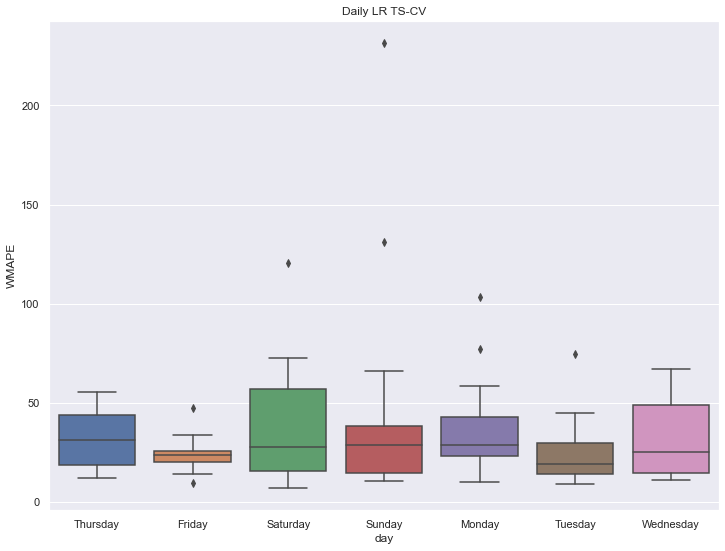

In [97]:
sns.boxplot(daily_diff_cv_perf_df, x='day', y='WMAPE')
plt.title('Daily LR TS-CV')

Worse (general daily mean and variance) than the non-differenced target, it is expected since power production is mostly about weather condition and differencing assumes that the weather conditions were same 3 days ago.

## Hourly Analysis

In [98]:
y_hourly = energy_prod_df['production']
y_hourly = np.clip(y_hourly, a_min=0, a_max=10)

1

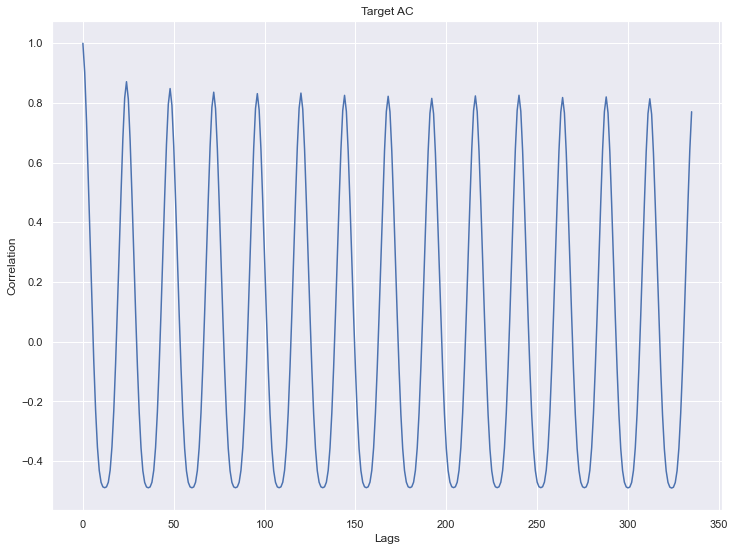

In [99]:
best_autocor_lag, _ = get_best_lag(y_hourly, y_hourly, 24*14, x_label='Lags', y_label='Correlation', title='Target AC')
best_autocor_lag

Text(0.5, 1.0, 'Target PACF')

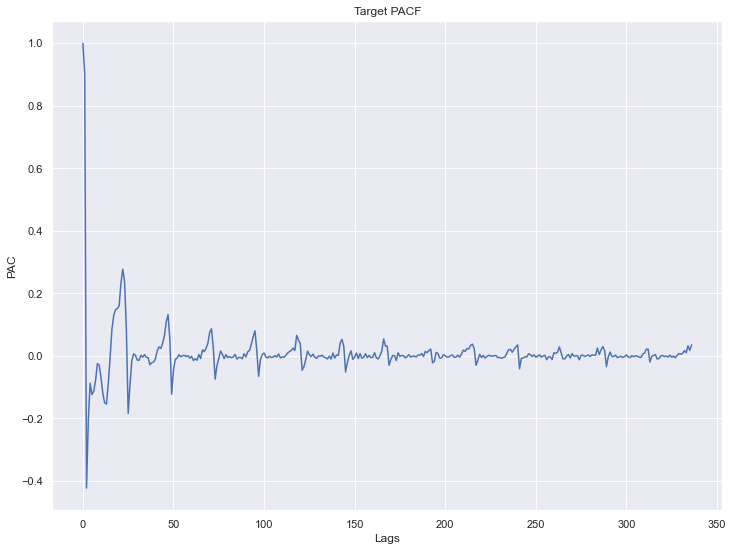

In [100]:
pacf_vals = sm.tsa.pacf(y_hourly, nlags=24*14)
plt.plot(pacf_vals)
plt.xlabel('Lags')
plt.ylabel('PAC')
plt.title('Target PACF')

Minimum lag available is lag 72, which have very little correlation with the target. So, we can't use the observed AR pattern to improve the model.

1

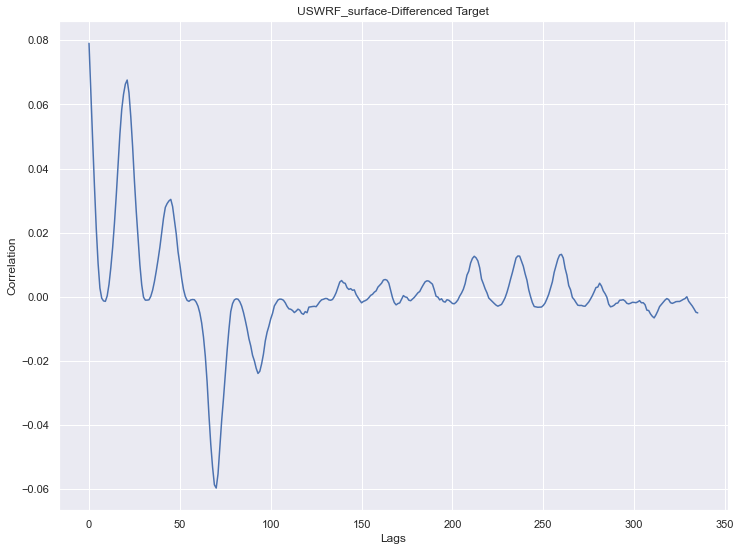

In [101]:
y_hourly_diff = (y_hourly - y_hourly.shift(72)).dropna()
best_dlwrf_lag, dlwrf_lag_cors = get_best_lag(energy_prod_df.loc[y_hourly_diff.index, 'uswrf_surface'], y_hourly_diff, 24*14, 'Lags', 'Correlation', 'USWRF_surface-Differenced Target')
np.argmax(np.abs(dlwrf_lag_cors[20:40]))

All features are checked in this manner to get their proper lags as potential features, only temperature feature is eliminated.

### LR Model w/Hourly Target

In [102]:
X_hourly = sm.add_constant(energy_prod_df.drop(['tcdc_low.cloud.layer', 'tcdc_middle.cloud.layer', 'tcdc_high.cloud.layer', 'tcdc_entire.atmosphere',
                                                'tmp_surface', 'production', 'hour', 'date'], axis=1))
X_hourly['Cloud_level'] = (energy_prod_df['tcdc_entire.atmosphere'] + energy_prod_df['tcdc_low.cloud.layer'])/2
X_hourly['CSNOW>.5'] = np.where(X_hourly['csnow_surface'] > .5, 1, 0)
X_hourly = X_hourly.join(pd.get_dummies(energy_prod_df['hour']).astype(int).drop(zero_prod_hours, axis=1))
dswrf_feature_df = get_feature_lag(X_hourly, 'dswrf_surface', 12, 1)
uswrf_feature_df = get_feature_lag(X_hourly, 'uswrf_top_of_atmosphere', 12, 1)
csnow_feature_df = get_feature_lag(X_hourly, 'csnow_surface', 12, 1)
cloud_lvl_feature_df = get_feature_lag(X_hourly, 'Cloud_level', 12, 1)
X_hourly = X_hourly.join(dswrf_feature_df).join(uswrf_feature_df).join(csnow_feature_df).join(cloud_lvl_feature_df)

X_hourly = X_hourly.loc[y_hourly.index]
X_hourly = X_hourly.dropna()
X_hourly = X_hourly[~X_hourly.index.isin(zero_prod_hr_idx)]
y_hourly = y_hourly.loc[X_hourly.index]

In [103]:
# Initial lasso to select the base features
base_hourly_lasso = LassoCV(alphas=np.logspace(-6, 2, 500), max_iter=10000, random_state=0)
X_hourly_scaled = base_scaler.fit_transform(X_hourly.values)
X_hourly_scaled[:, 0] = 1
base_hourly_lasso.fit(X_hourly_scaled, y_hourly)
base_hourly_lasso.score(X_hourly_scaled, y_hourly)

0.7763949933908572

In [104]:
base_hourly_lr_coefs = base_hourly_lasso.coef_
selected_cols = X_hourly.columns[base_hourly_lr_coefs!=0].tolist()
selected_cols

['dswrf_surface',
 'uswrf_top_of_atmosphere',
 'csnow_surface',
 'dlwrf_surface',
 'uswrf_surface',
 'Cloud_level',
 'CSNOW>.5',
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 'dswrf_surface- lag1',
 'dswrf_surface- lag2',
 'dswrf_surface- lag4',
 'dswrf_surface- lag5',
 'dswrf_surface- lag6',
 'dswrf_surface- lag7',
 'dswrf_surface- lag8',
 'dswrf_surface- lag9',
 'dswrf_surface- lag10',
 'dswrf_surface- lag12',
 'uswrf_top_of_atmosphere- lag1',
 'uswrf_top_of_atmosphere- lag2',
 'uswrf_top_of_atmosphere- lag3',
 'uswrf_top_of_atmosphere- lag4',
 'uswrf_top_of_atmosphere- lag5',
 'uswrf_top_of_atmosphere- lag7',
 'uswrf_top_of_atmosphere- lag8',
 'uswrf_top_of_atmosphere- lag10',
 'uswrf_top_of_atmosphere- lag11',
 'csnow_surface- lag1',
 'csnow_surface- lag2',
 'csnow_surface- lag3',
 'csnow_surface- lag4',
 'csnow_surface- lag5',
 'csnow_surface- lag6',
 'csnow_surface- lag7',
 'csnow_surface- lag9',
 'csnow_surface- lag11',
 'Cloud_level- lag1',
 'Cloud_level- la

In [105]:
lr_hourly_sm = sm.OLS(y_hourly, sm.add_constant(X_hourly[selected_cols])).fit()
lr_hourly_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             production   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     743.5
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:11:31   Log-Likelihood:                -24738.
No. Observations:               12239   AIC:                         4.959e+04
Df Residuals:                   12181   BIC:                         5.002e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              2.8247      0.135     20.886      0.000       2.560       3.090
dswrf_surface                      0.0055      0.000     12.442      0.000       0.005       0.006
uswrf_top_of_atmosphere           -0.0036      0.001     -3.946      0.000      -0.005      -0.002
csnow_surface                     -1.0448      0.523     -1.998      0.046      -2.070      -0.020
dlwrf_surface                      0.0005      0.001      0.808      0.419      -0.001       0.002
uswrf_surface                      0.0037      0.001      6.361      0.000       0.003       0.005
Cloud_level                       -0.0252      0.004     -6.512      0.000      -0.033      -0.018
CSNOW>.5                          -0.2678      0.168     -1.592      0.111      -0.598       0.062
5                                 -2.6803      0.146    -18.389      0.000      -2.966      -2.395
6                                 -2.5154      0.133    -18.845      0.000      -2.777      -2.254
7                                 -1.2046      0.136     -8.834      0.000      -1.472      -0.937
8                                  2.0123      0.144     14.014      0.000       1.731       2.294
9                                  4.2471      0.104     40.646      0.000       4.042       4.452
10                                 3.9354      0.242     16.257      0.000       3.461       4.410
11                                 4.3184      0.236     18.334      0.000       3.857       4.780
12                                 4.3761      0.197     22.225      0.000       3.990       4.762
13                                 4.0525      0.201     20.113      0.000       3.658       4.447
14                                 1.8057      0.259      6.959      0.000       1.297       2.314
15                                -2.0759      0.204    -10.191      0.000      -2.475      -1.677
16                                -4.3631      0.227    -19.238      0.000      -4.808      -3.919
17                                -4.9668      0.230    -21.555      0.000      -5.418      -4.515
18                                -4.1166      0.232    -17.712      0.000      -4.572      -3.661
dswrf_surface- lag1               -0.0025      0.001     -4.049      0.000      -0.004      -0.001
dswrf_surface- lag2               -0.0013      0.001     -2.388      0.017      -0.002      -0.000
dswrf_surface- lag4                0.0007      0.001      1.145      0.252      -0.000       0.002
dswrf_surface- lag5                0.0032      0.001      4.586      0.000       0.002       0.005
dswrf_surface- lag6                0.0028      0.001      4.162      0.000       0.001       0.004
dswrf_surface- lag7               -0.0037      0.001     -5.610      0.000      -0.005      -0.002
dswrf_surface-

In [106]:
# Selected with considering significance & test trials
sm_drop_cols = ['dswrf_surface- lag10', 'uswrf_top_of_atmosphere- lag2', 'csnow_surface- lag1', 'csnow_surface- lag2',
                'csnow_surface- lag7', 'csnow_surface- lag11', 'Cloud_level- lag7', 'Cloud_level- lag11',
                'dswrf_surface- lag4', 'csnow_surface- lag5', 'Cloud_level- lag1', 'Cloud_level- lag10', 'Cloud_level- lag2',
                'dswrf_surface- lag2', 'csnow_surface- lag4', 'Cloud_level- lag4', 'Cloud_level- lag6', 'dlwrf_surface',
                'CSNOW>.5', 'uswrf_top_of_atmosphere- lag8', 'uswrf_top_of_atmosphere- lag7', 'csnow_surface- lag9',
                'uswrf_top_of_atmosphere- lag3', 'uswrf_top_of_atmosphere- lag4', 'uswrf_top_of_atmosphere- lag10']

X_hourly = X_hourly[selected_cols].drop(sm_drop_cols, axis=1)

In [107]:
lr_hourly_sm = sm.OLS(y_hourly, sm.add_constant(X_hourly)).fit()
lr_hourly_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             production   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1314.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        12:11:31   Log-Likelihood:                -24786.
No. Observations:               12239   AIC:                         4.964e+04
Df Residuals:                   12206   BIC:                         4.988e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              2.9073      0.063     46.484      0.000       2.785       3.030
dswrf_surface                      0.0057      0.000     13.574      0.000       0.005       0.007
uswrf_top_of_atmosphere           -0.0049      0.001     -5.917      0.000      -0.007      -0.003
csnow_surface                     -1.6256      0.237     -6.863      0.000      -2.090      -1.161
uswrf_surface                      0.0036      0.000      7.467      0.000       0.003       0.005
Cloud_level                       -0.0124      0.002     -7.430      0.000      -0.016      -0.009
5                                 -2.7631      0.127    -21.818      0.000      -3.011      -2.515
6                                 -2.2682      0.119    -19.049      0.000      -2.502      -2.035
7                                 -1.1706      0.106    -10.997      0.000      -1.379      -0.962
8                                  1.7838      0.094     19.043      0.000       1.600       1.967
9                                  4.4227      0.086     51.221      0.000       4.253       4.592
10                                 4.1090      0.236     17.391      0.000       3.646       4.572
11                                 4.4854      0.118     37.947      0.000       4.254       4.717
12                                 4.1890      0.126     33.376      0.000       3.943       4.435
13                                 3.5567      0.126     28.179      0.000       3.309       3.804
14                                 2.2343      0.121     18.478      0.000       1.997       2.471
15                                -2.0678      0.163    -12.717      0.000      -2.386      -1.749
16                                -4.3790      0.185    -23.643      0.000      -4.742      -4.016
17                                -4.8351      0.178    -27.096      0.000      -5.185      -4.485
18                                -4.3896      0.197    -22.296      0.000      -4.776      -4.004
dswrf_surface- lag1               -0.0034      0.000     -7.301      0.000      -0.004      -0.002
dswrf_surface- lag5                0.0033      0.000      7.093      0.000       0.002       0.004
dswrf_surface- lag6                0.0026      0.001      4.001      0.000       0.001       0.004
dswrf_surface- lag7               -0.0037      0.001     -5.966      0.000      -0.005      -0.002
dswrf_surface- lag8               -0.0023      0.001     -4.085      0.000      -0.003      -0.001
dswrf_surface- lag9               -0.0095      0.001    -12.922      0.000      -0.011      -0.008
dswrf_surface- lag12               0.0048      0.000     14.762      0.000       0.004       0.005
uswrf_top_of_atmosphere- lag1      0.0034      0.001      3.697      0.000       0.002       0.005
uswrf_top_of_a

There is high correlation, but it is okey since this model is for demonstration only.

In [ ]:
# Don't want outlier dates in the test since we think that their response is very noisy, therefore can add bias to our tests (Only 12 May is removed with this)
cv_dates = y_daily.index[(y_daily.index >= '2024-02-01') & (y_daily.index <= '2024-05-15') & (~y_daily.index.isin(outlier_dates.tolist()))].unique()
hourly_cv_df = production_df[production_df['date'].isin(cv_dates)].copy()
hourly_cv_df['Prediction'] = None

# TS-CV for daily series
for i, date in enumerate(cv_dates):
    cv_comp_perc = round((i+1)*100/len(cv_dates), 2)
    if cv_comp_perc%10 < len(cv_dates)/10:
        print(f'Iteration {i+1}, Completion %: {cv_comp_perc}')
    
    iter_cv_idx = hourly_cv_df[hourly_cv_df['date']==date].index
    X_tr_iter, X_test_iter = split_cv_hourly(X_hourly, date, energy_prod_df)
    y_tr_iter, _ = split_cv_hourly(y_hourly.loc[X_hourly.index], date, energy_prod_df)
    # Train LR & predict test point
    daily_sm_lr = sm.OLS(y_tr_iter, X_tr_iter).fit()

    # Predict hourly productions
    hourly_cv_df.loc[iter_cv_idx, 'Prediction'] = [0]*5 + daily_sm_lr.predict(X_test_iter).tolist() + [0]*5

hourly_cv_df['Error'] = hourly_cv_df['production'] - hourly_cv_df['Prediction']

In [109]:
hourly_cv_df['Error'].abs().sum()*100/hourly_cv_df['production'].sum()

29.129685905827998

In [110]:
hourly_cv_df.iloc[-24:]['Error'].abs().sum()*100/hourly_cv_df.iloc[-24:]['production'].sum()

29.251685018754458

In [111]:
hourly_cv_df.iloc[-24*7:]['Error'].abs().sum()*100/hourly_cv_df.iloc[-24*7:]['production'].sum()

29.167567213996485

In [112]:
hourly_cv_df.iloc[-24*30:]['Error'].abs().sum()*100/hourly_cv_df.iloc[-24*30:]['production'].sum()

26.014446647868

<ipython-input-113-fea48a8dc864>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_cv_perf_df = hourly_cv_df.groupby('date').apply(process_cv_df)


Text(0.5, 1.0, 'Daily LR TS-CV')

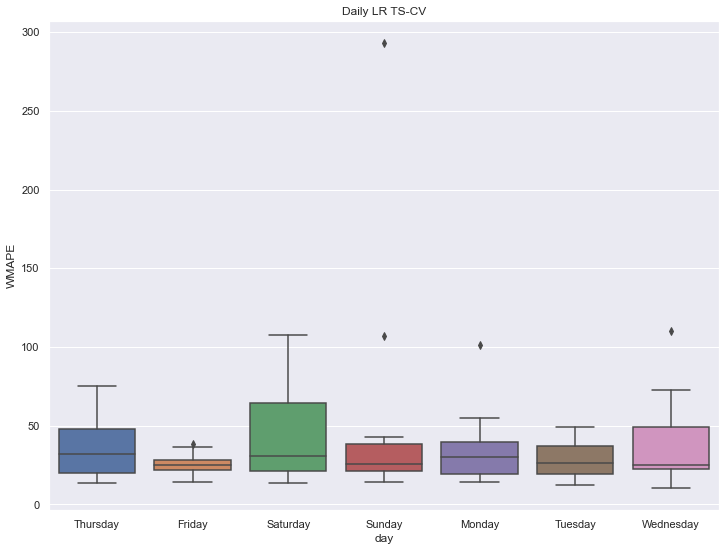

In [113]:
hourly_cv_perf_df = hourly_cv_df.groupby('date').apply(process_cv_df)
hourly_cv_perf_df['day'] = hourly_cv_perf_df.index.day_name()

sns.boxplot(hourly_cv_perf_df, x='day', y='WMAPE')
plt.title('Daily LR TS-CV')

Worse (general daily mean and variance) than the daily models as we expected.

## Model Comparison

In the competition, we choosed to use the LR model with daily energy production as target only. This is because we didn't have time to finalize all models for the competition phase to ensemble them in a meaningful way and it has the lowest mean WMAPE in the TS-CV.

In [114]:
# Create common test df to analyze all models at the same time
daily_cv_perf_df['model'] = 'Daily LR'
daily_diff_cv_perf_df['model'] = 'Daily Diff LR'
hourly_cv_perf_df['model'] = 'Hourly LR'

model_comp_df = pd.concat((daily_cv_perf_df, daily_diff_cv_perf_df, hourly_cv_perf_df), axis=0)

Text(0.5, 1.0, 'Model Comparison Boxplot')

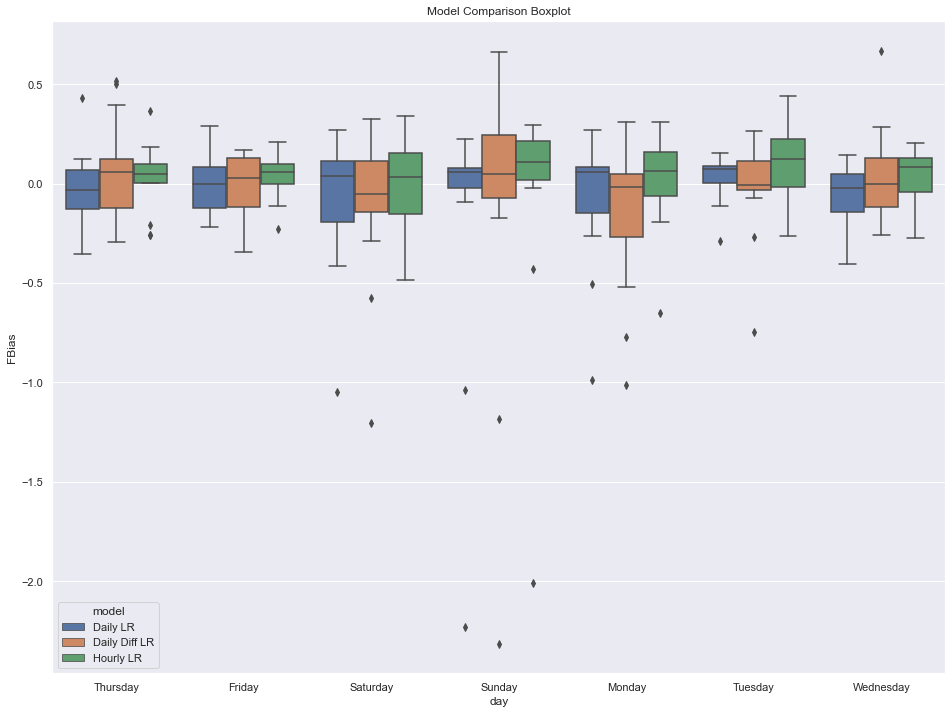

In [115]:
plt.figure(figsize=(16, 12))
sns.boxplot(model_comp_df, x='day', y='FBias', hue='model')
plt.title('Model Comparison Boxplot')

Daily LR model seems best in general(mean error and variance), which alligns with WMAPE means. However, we think that it would be beneficial to ensemble Daily LR and Daily Diff LR models. Since they generally have opposite forecasting biases, their combination might improve the forecasts a bit.

## Conclusion & Future Work

In this project, our objective was to forecast the solar power production values of Edikli GES for the upcoming 24 to 48 hours, utilizing both weather and production data which was available starting from day before. To ensure the accuracy of our predictions during the competition phase, held from the 13th to the 26th of May, we undertook the task of constructing various time series models while only considering the models and methodologies taught in the class.

Following a comparison of these models with time series cross validation, we determined that the Linear Regression model with daily target demonstrated the most promising results. Consequently, we based our predictions on this model throughout the competition phase, to increase reliability in our approach.

Better disaggregation methods such as clustering days based on hourly features and disaggregating based on these clusters might improve the performance of the daily models. Another modelling improvement can be ensembling two daily models, which might potentially lower the errors since their forecast biases have different signs in different days. Also, if the inside mechanisms of the power plant (such as breakdown times, exact locations of the cells, ...) can be known, then some modifications can be made to make the models learn the stucture better.

## References

- Martín, L., Torres, J., & Villalba, P. (2010). Methodologies for predicting global solar irradiance. Journal of Solar Energy Engineering, 132(4), 041011. doi:10.1115/1.4001815

- Bacher, P., Madsen, H., & Nielsen, H. A. (2009). Online short-term solar power forecasting. Solar Energy, 83(10), 1772-1783. doi:10.1016/j.solener.2009.05.016

- Sugianto, A. (2020). Comparative analysis of solar cell efficiency between monocrystalline and polycrystalline. International Journal of Renewable Energy Research, 10(2), 437-442.

## Contributors:

Oğuzhan Engin - 2019402009

Serhat Ekli - 2020402051

Halil İbrahim Türkmen - 2016402006